## Fitting 
Now that we know how to manipulate the data, it's time to fit it and extract some model parameters. Details on fitting are found in the manual: https://pace-neutrons.github.io/Horace/v4.0.0/manual/Multifit.html. 

First, we will fit to a hand-written function of the excitations. We will do this by making 1d cuts through the data. Of course, we have to select the right cuts to do this. We therefore first inspect the data. Then, we will make cuts at two values of k - the first one has better statistics, but doesn't cover the excitation up to high energy, while the second one has poorer statistics, but does cover the excitation.

Interface opened
All features have moved to hor_config
> In herbert_config (line 3)Warning: Cannot find test path, possible failed setup
!==================================================================!
!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!
All features have moved to hor_config
!==================================================================!
!                           Horace 4.0.0                           !
!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !
!                                                                  !
!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                 

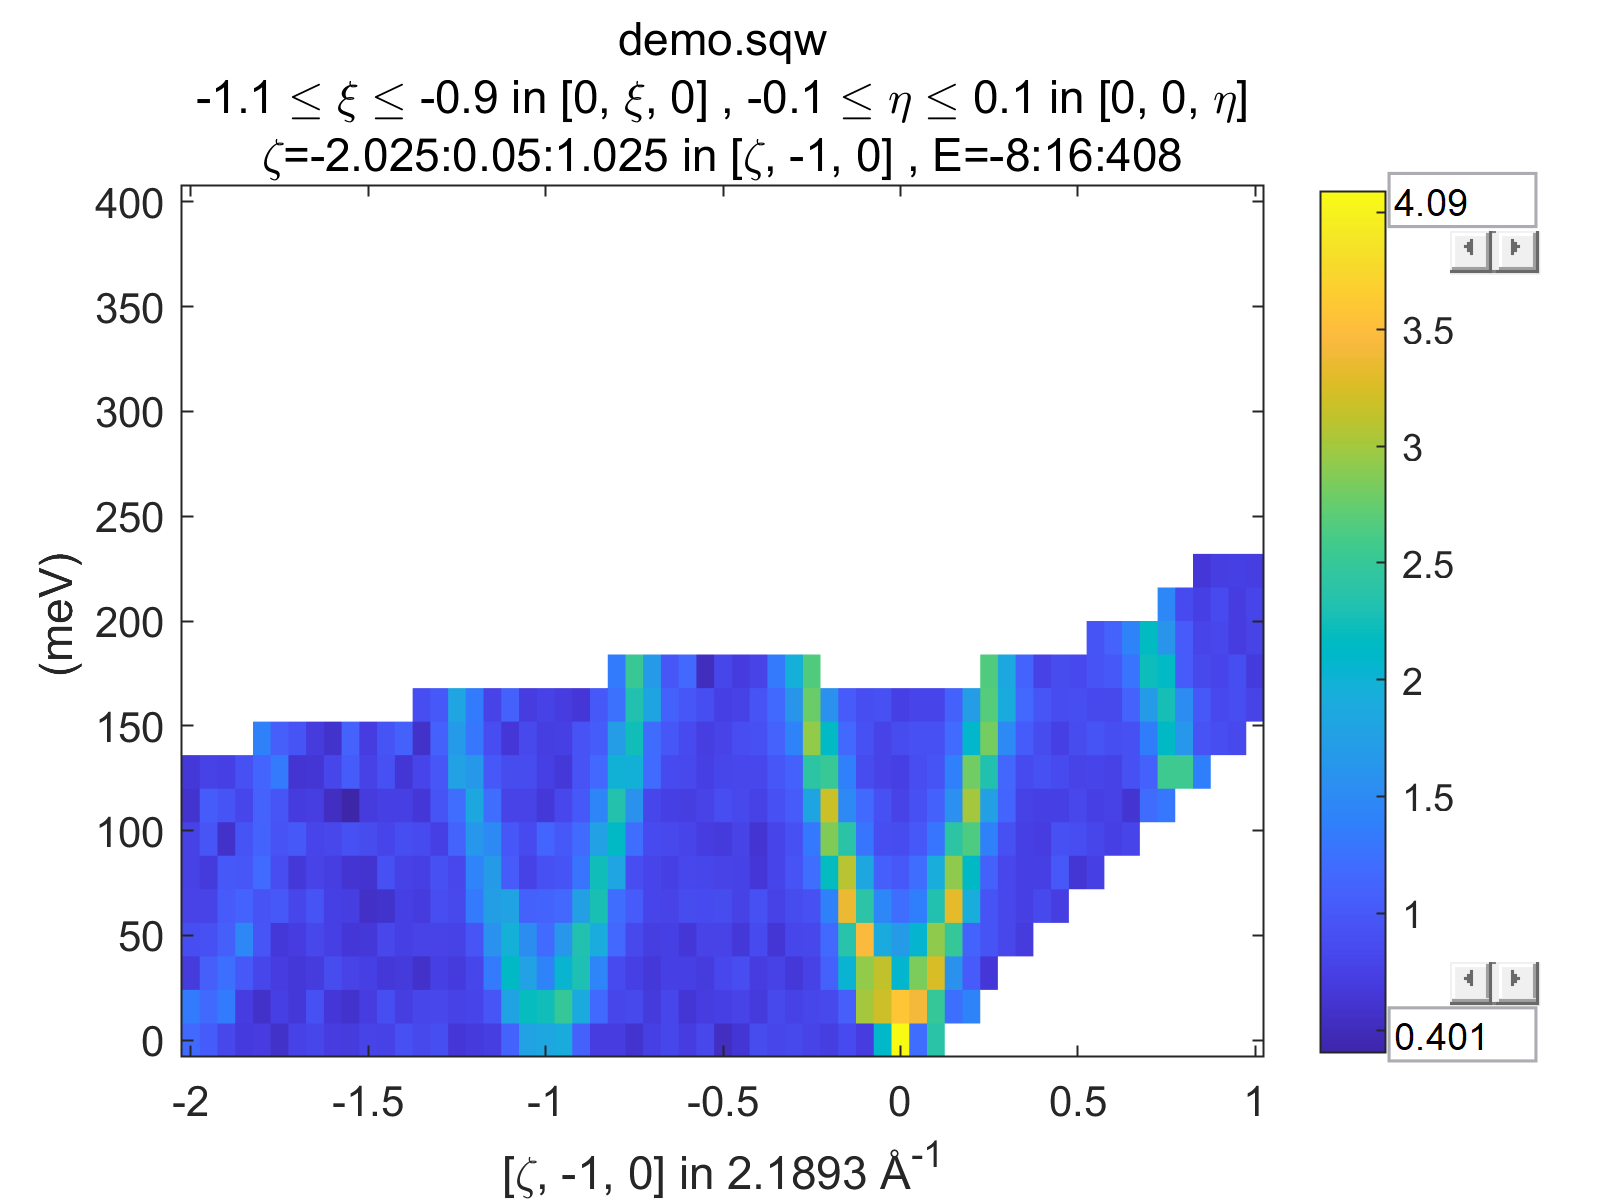

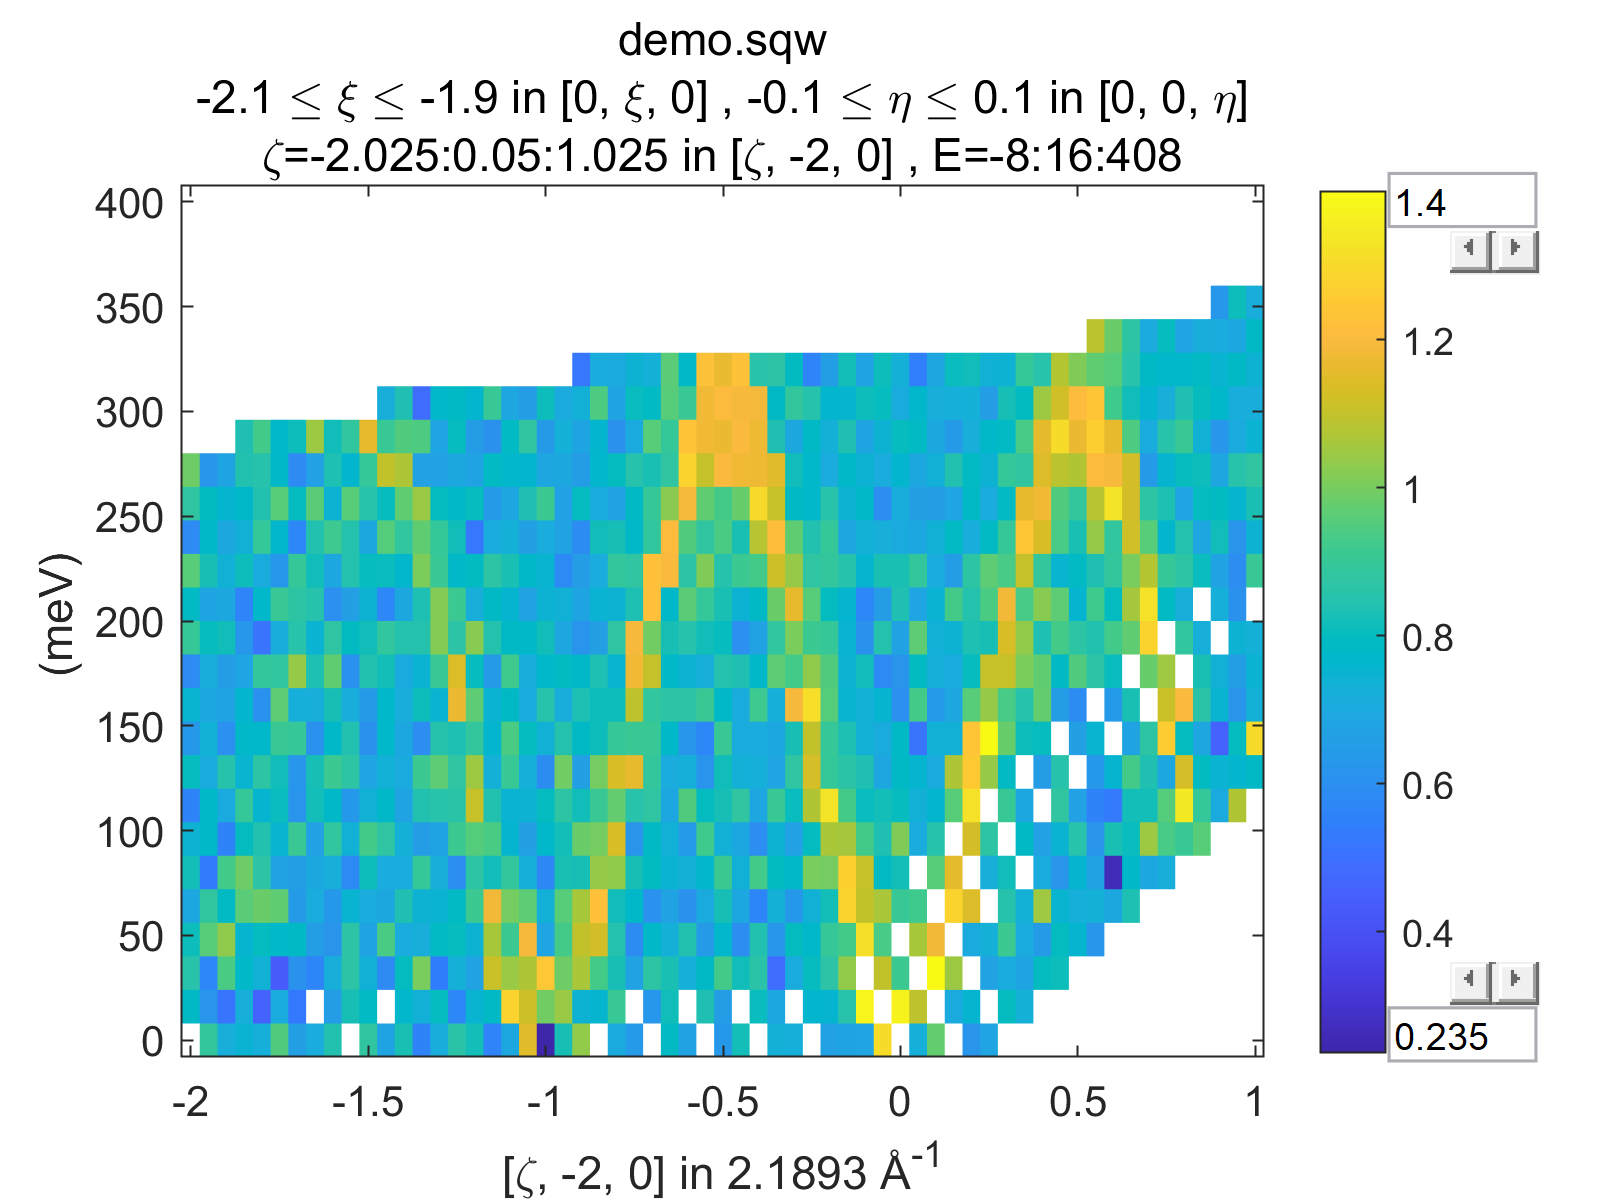

In [1]:
from pace_neutrons import Matlab
m = Matlab() 

sqw_file = 'demo.sqw'
proj = {
    'u': [1, 0, 0],
    'v': [0, 1, 0],
    'type': 'rrr'
}

%matlab_plot_mode inline inline
%matlab_fig -w 1600 -h 1200 
# 2D slice
cc1 = m.cut_sqw(sqw_file, proj, [-2, 0.05, 1], [-1-0.1, -1+0.1], [-0.1, 0.1], [0, 16, 400])
m.plot(cc1)
m.keep_figure()

cc2 = m.cut_sqw(sqw_file, proj, [-2, 0.05, 1], [-2-0.1, -2+0.1], [-0.1, 0.1], [0, 16, 400])
m.plot(cc2)
m.keep_figure()



We will make a few cuts of this data to see how they look. Next, we'll make a series of cuts and put in a list for futher work.

*** Step 1 of 1; Read data for    16098 pixels -- processing data... ----->  retained      3981 pixels
*** Step 1 of 1; Read data for    17913 pixels -- processing data... ----->  retained      8145 pixels


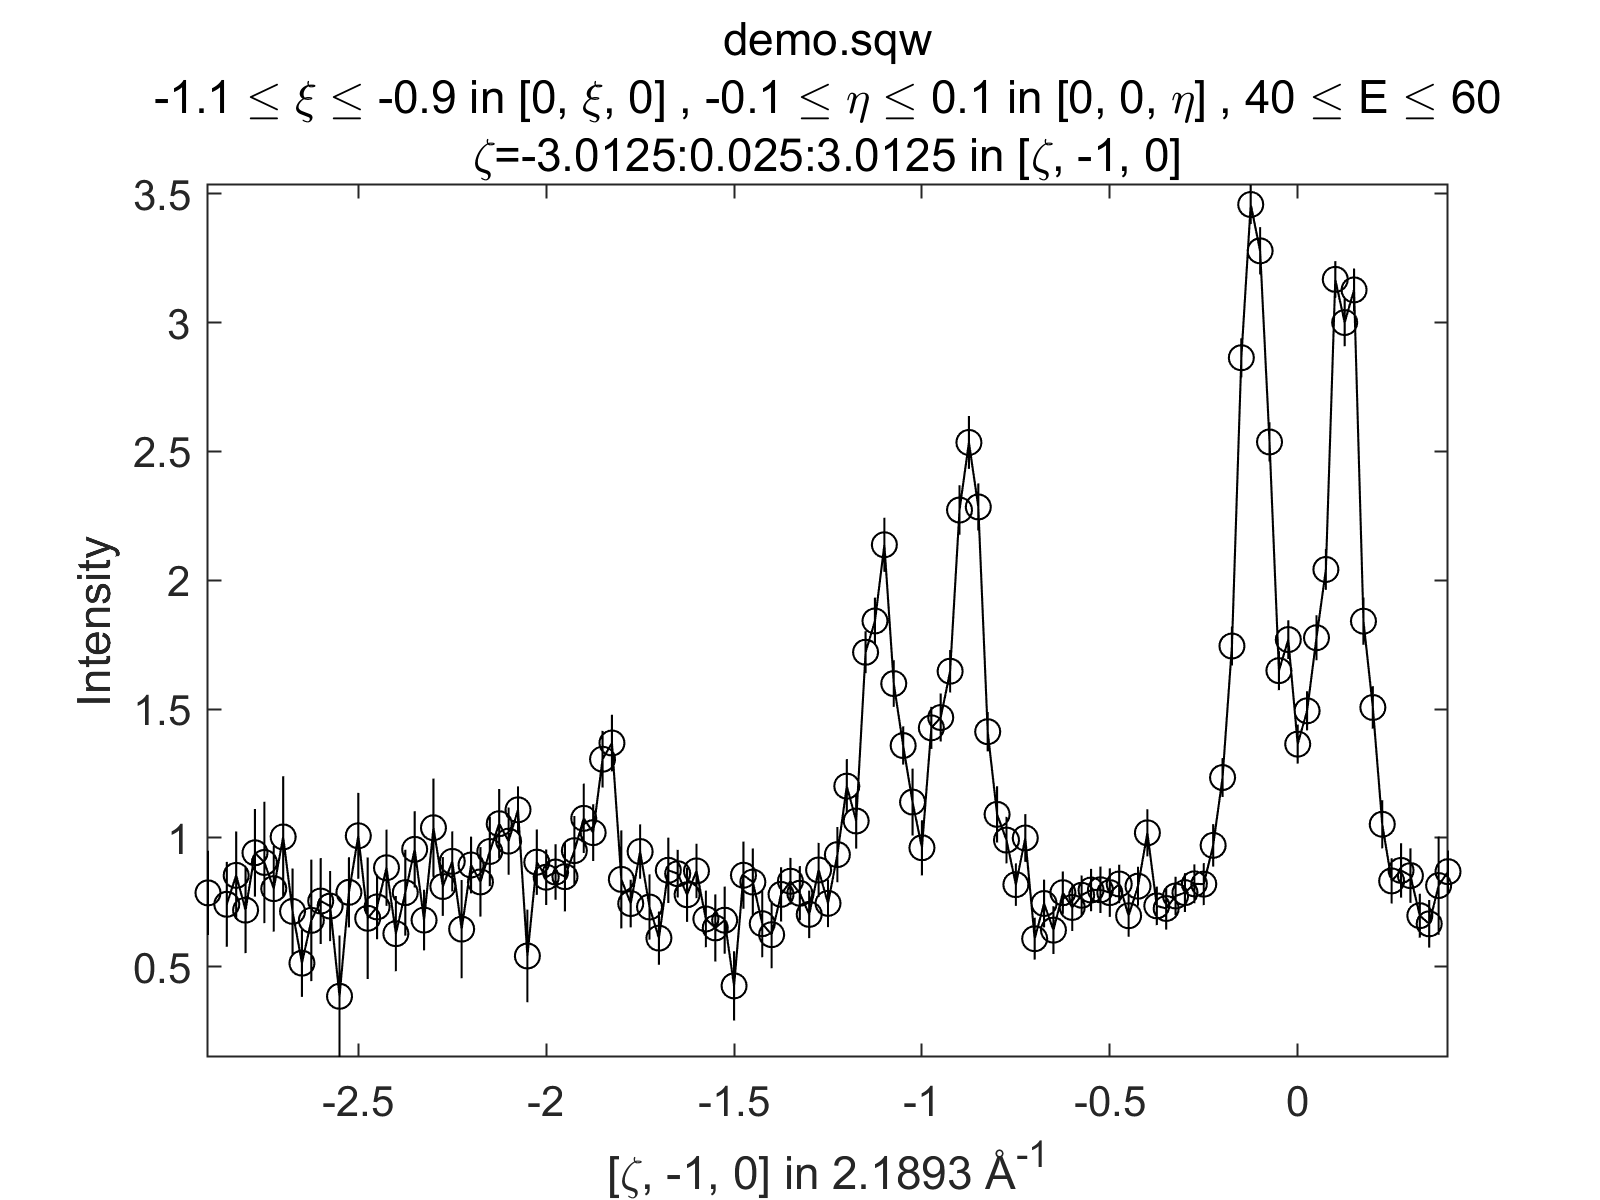

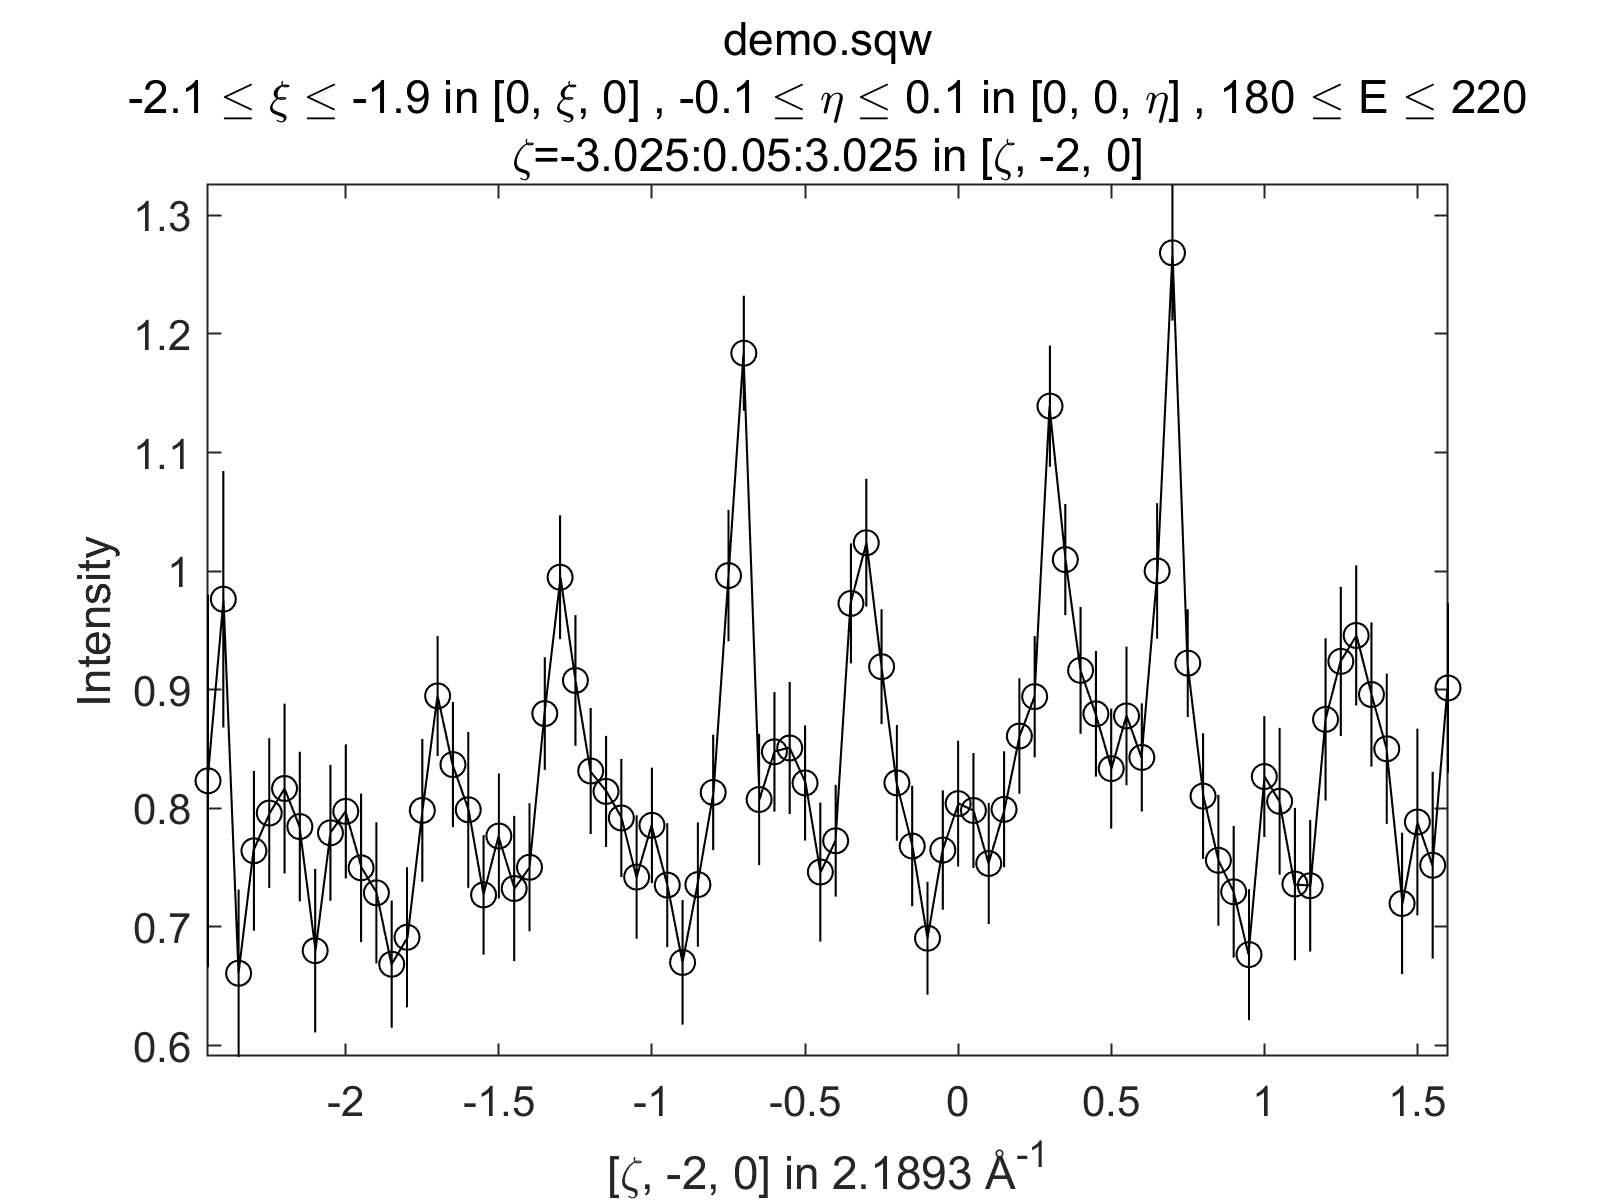

In [2]:
cut_example_1=m.cut_sqw(sqw_file, proj, [-3,0.025,3], [-1.1,-0.9], [-0.1,0.1], [40,60])
%matlab_fig -w 1600 -h 1200 
m.dd(cut_example_1) #dd stands for "draw data", which plots the data with a line through it
m.keep_figure()
cut_example_2=m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-2.1,-1.9], [-0.1,0.1], [180,220])
m.dd(cut_example_2)
m.keep_figure()


To fit the data, we need to define a model. This is most easily done in Python. Below, we define a model of spin waves, which is identical to the one used to generate the data. 

In [3]:
import numpy as np
def fm_sqw(h, k, l, e, p):
    """
    Compute the dynamic structure factor S(Q, ω) for Fe using a Damped Harmonic Oscillator (DHO) model.

    Parameters
    ----------
    h, k, l : float or array-like
        Miller indices components.
    e : float or array-like
        Energy transfer (meV).
    p : list or array-like
        Model parameters:
        p[0] = J      (exchange constant)
        p[1] = Delta  (spin gap)
        p[2] = Gamma  (damping)
        p[3] = T      (temperature in K)
        p[4] = scale  (intensity scale factor)

    Returns
    -------
    S : float or array-like
        The scattering function S(Q, ω).
    """
    # Unpack parameters
    J, Delta, Gamma, T, scale = p

    # DHO dispersion relation
    omega = Delta + 4 * J * (
        np.sin(np.pi * h)**2 + 
        np.sin(np.pi * k)**2 + 
        np.sin(np.pi * l)**2
    )

    # Form factor parameters (Fe)
    A, a = 0.0706, 35.008
    B, b = 0.3589, 15.358
    C, c = 0.5819, 5.561
    D = -0.0114

    # Q squared
    q_squared = ((1 / (2 * 2.87))**2) * (h**2 + k**2 + l**2)

    # Magnetic form factor
    ff = A * np.exp(-a * q_squared) + \
         B * np.exp(-b * q_squared) + \
         C * np.exp(-c * q_squared) + D

    # Bose factor (detailed balance)
    bose = e / (1 - np.exp(-11.602 * e / T))

    # Damped Harmonic Oscillator model
    numerator = 4 * Gamma * omega
    denominator = (e**2 - omega**2)**2 + 4 * (Gamma * e)**2
    dho = numerator / denominator

    return scale * (ff**2) * (1 / np.pi) * bose * dho

Let us evaluate this model and compare it to the cuts made above for a set of reasonable guesses of the parameter values. We evaluate the model on the points in the cut. Here's a neat thing about working with `sqw` files: Even though the figure below displays data at only a few points, there workspace contains the full information about the model calculation for every point making up the cut. To plot the model on top of the data, we first set the color of the data using `m.acolor('k')`, plot the data, then change the color to red, and use the `pl` command to draw the calculation.

The calculation is a decent representation of the data, although we of course need to handle the background. We could of course subtract it at shown in the previous notebook, but it can also be fitted. We'll get back to that shortly.

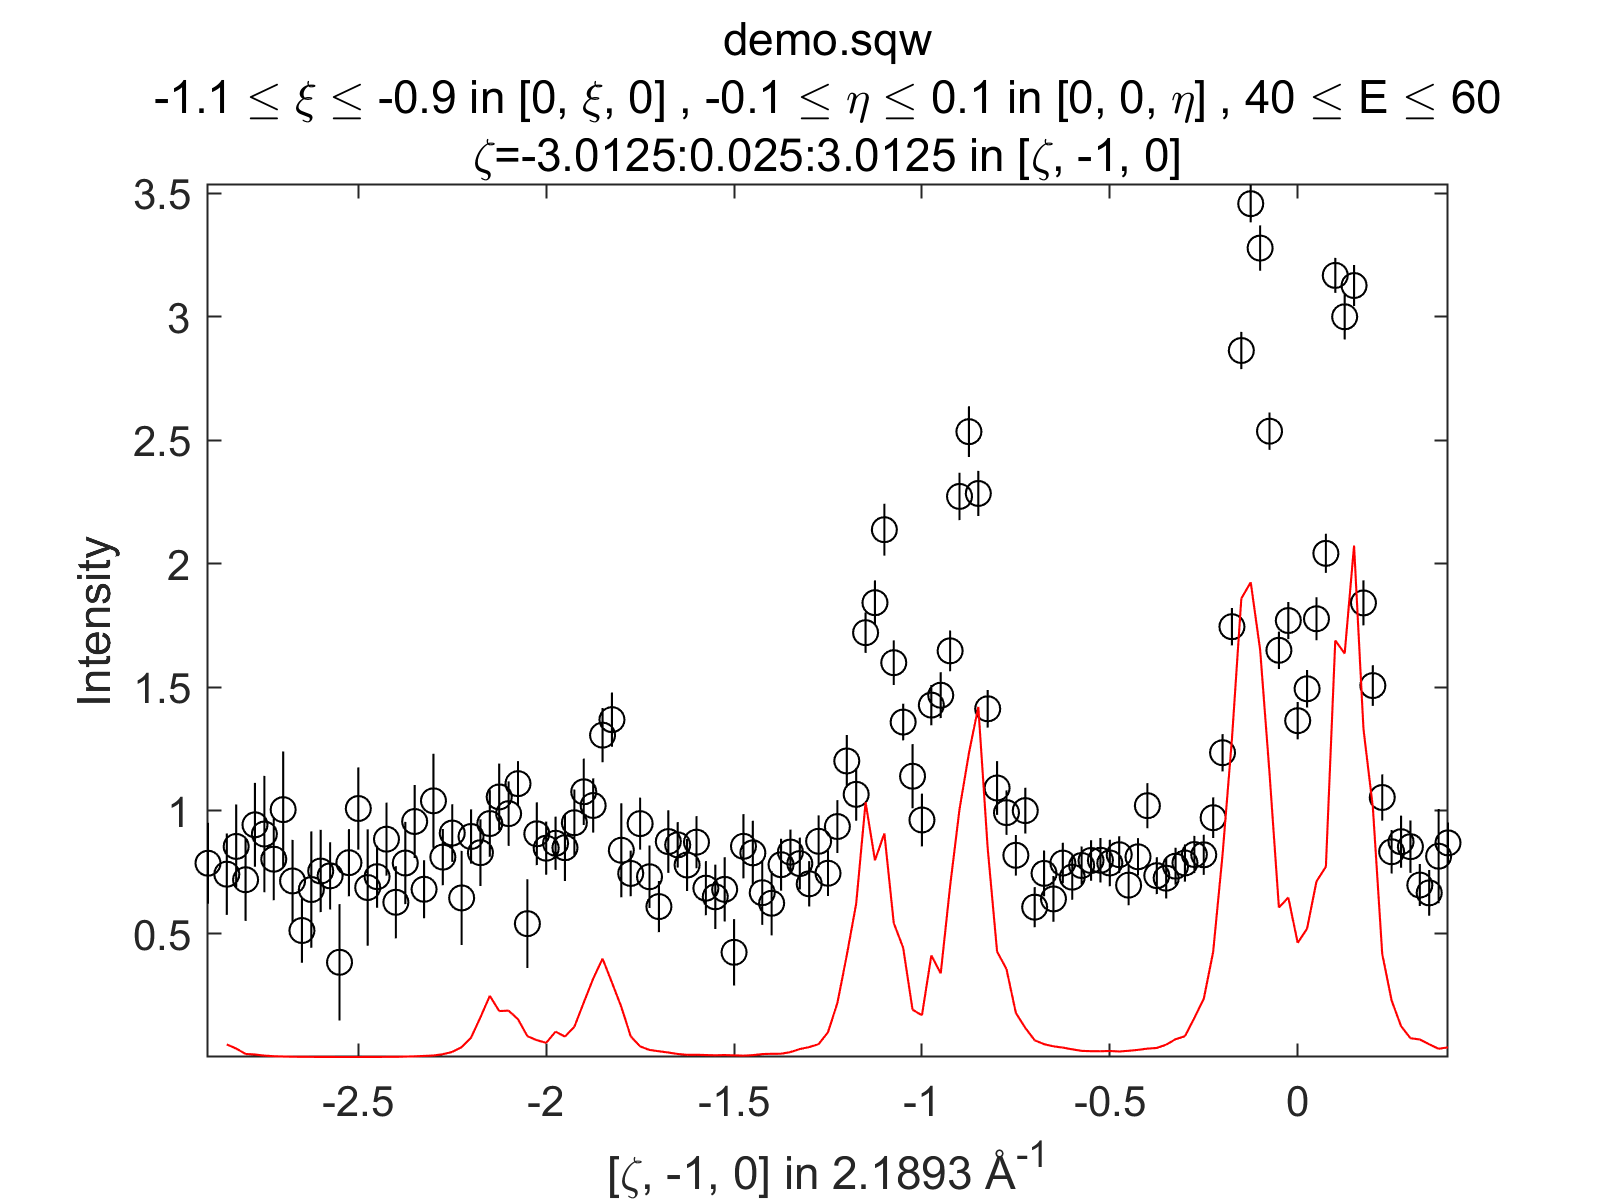

In [4]:
# Call with Python function
%matlab_fig -w 1600 -h 1200 
%matlab_plot_mode inline inline

w_cal_py = m.sqw_eval(cut_example_1[0], fm_sqw, [60, 0, 30, 10, 400])
m.acolor('k')
m.plot(cut_example_1[0]) #plot the result of the sqw_eval function
m.acolor('r')
m.pl(w_cal_py) #dl plots only a line through the data points

m.acolor('k') # change the default color back to black for later


We now make a series of 1D cuts of the data and collect them in a list for fitting. We plot a few of the cuts to check if they look reasonable.


*** Step 1 of 1; Read data for     9632 pixels -- processing data... ----->  retained      3478 pixels
*** Step 1 of 1; Read data for    10308 pixels -- processing data... ----->  retained      2518 pixels
*** Step 1 of 1; Read data for    11131 pixels -- processing data... ----->  retained      4165 pixels
*** Step 1 of 1; Read data for    12133 pixels -- processing data... ----->  retained      3083 pixels
*** Step 1 of 1; Read data for    21316 pixels -- processing data... ----->  retained      5163 pixels
*** Step 1 of 1; Read data for    21183 pixels -- processing data... ----->  retained      3881 pixels
*** Step 1 of 1; Read data for    22083 pixels -- processing data... ----->  retained      6753 pixels
*** Step 1 of 1; Read data for    21348 pixels -- processing data... ----->  retained      6996 pixels
*** Step 1 of 1; Read data for    17913 pixels -- processing data... ----->  retained      8145 pixels
*** Step 1 of 1; Read data for    32768 pixels -- processing data... ----

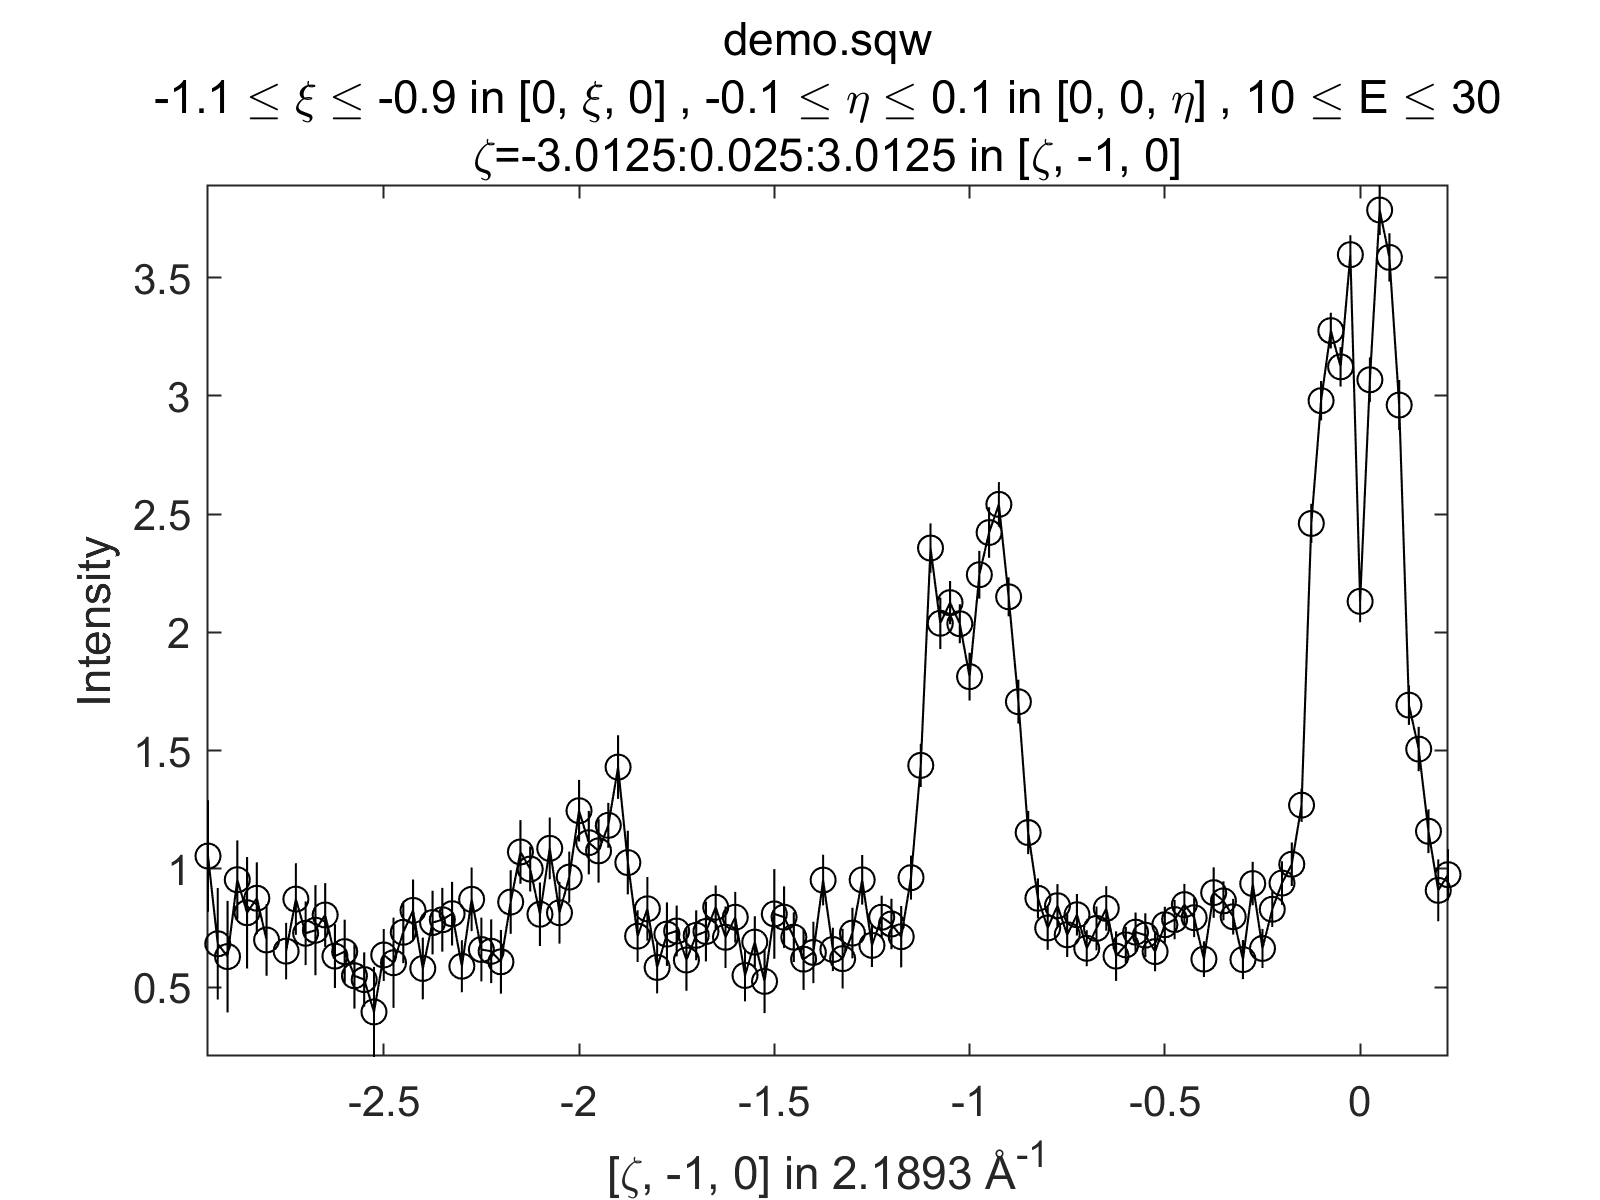

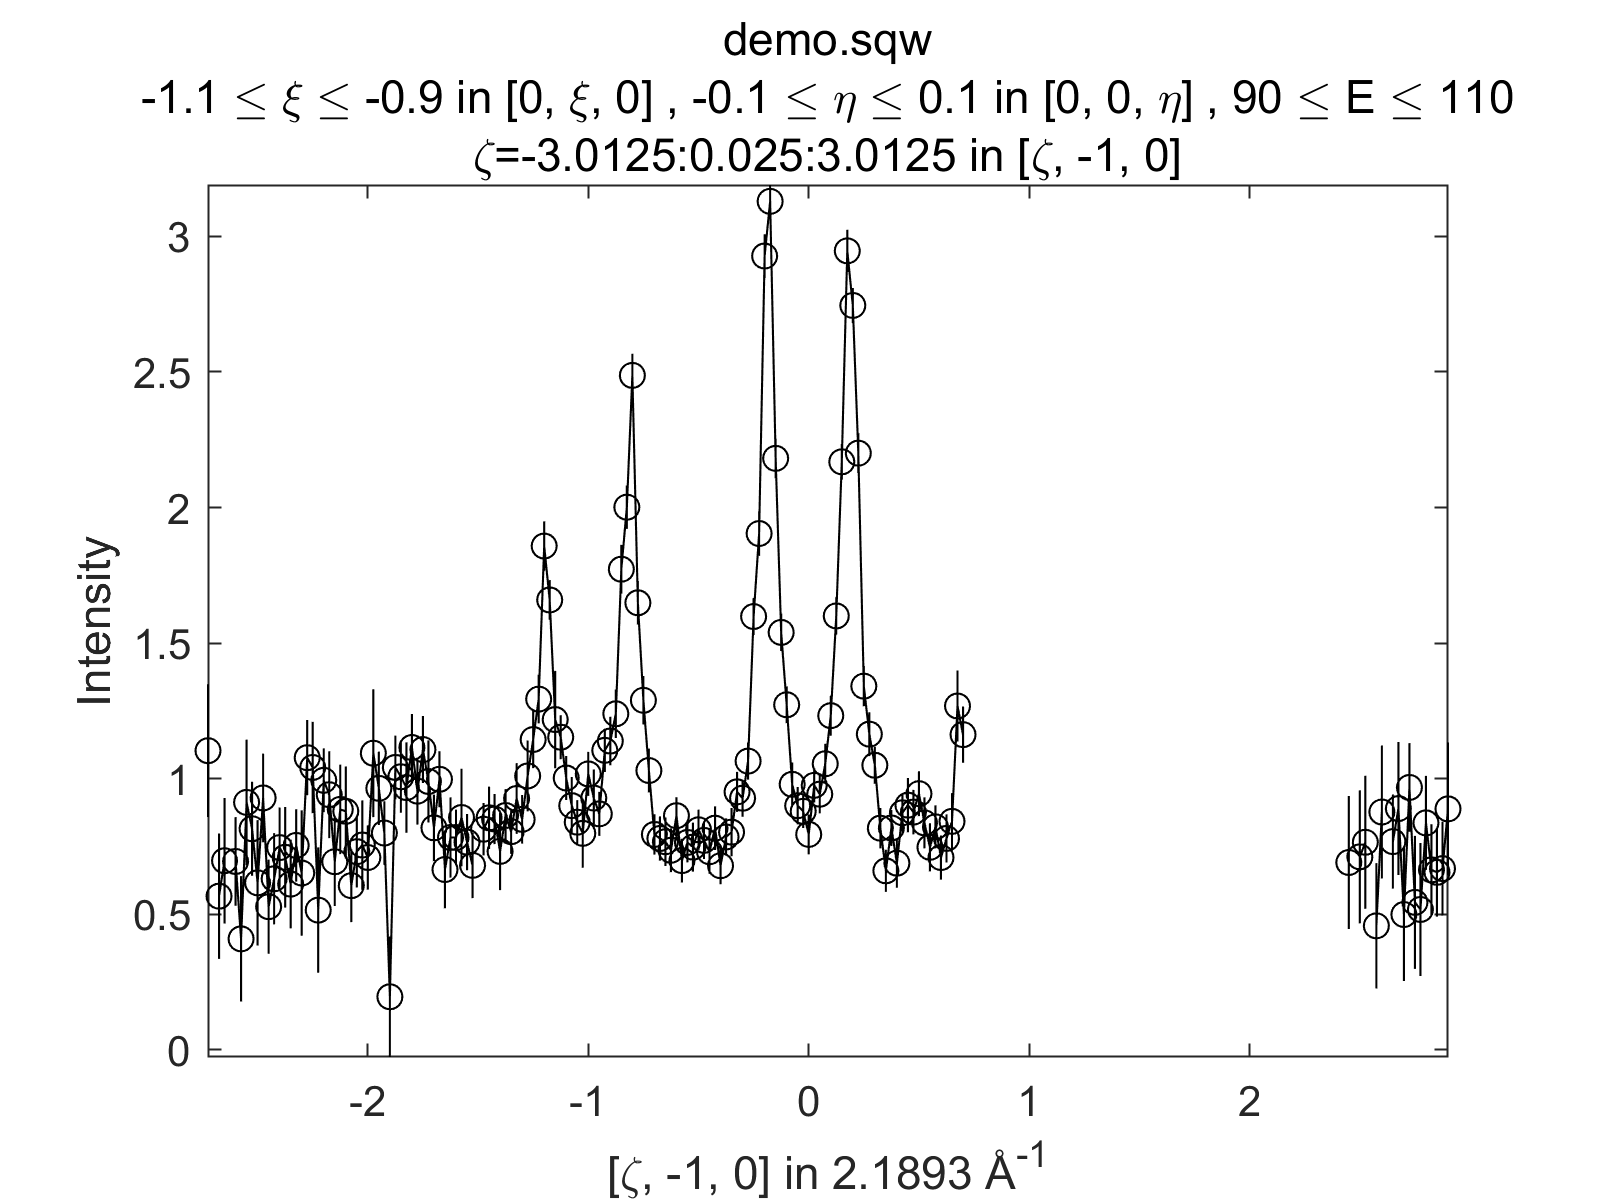

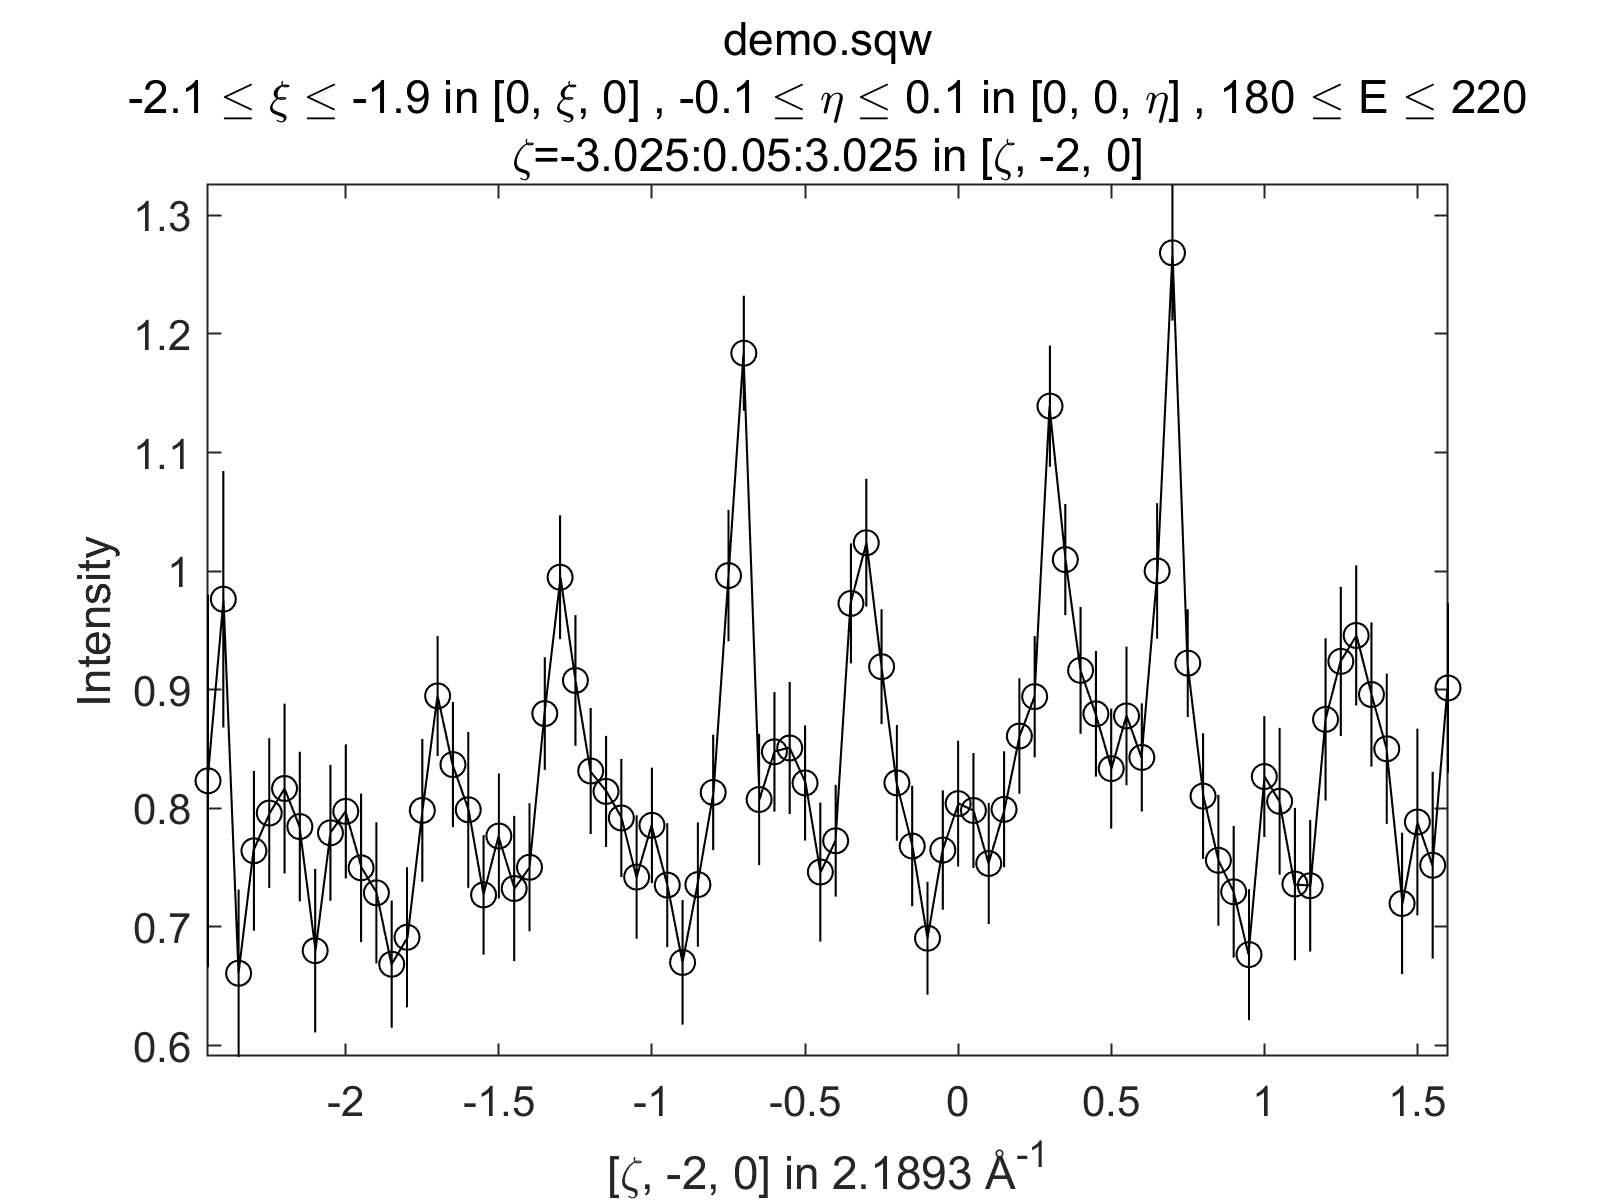

In [5]:
# Make a series of 1D cuts of the data
proj = {'u':[1,0,0], 'v':[0,1,0], 'type':'rrr'}
energy_range = range(20, 160, 20)
my_cuts = []

for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.025,3], [-1.1,-0.9], [-0.1,0.1], [-10+energy_range[i], 10+energy_range[i]]))

energy_range = range(160, 320, 40)
for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-2.1,-1.9], [-0.1,0.1], [-20+energy_range[i], 20+energy_range[i]]))

%matlab_fig -w 1600 -h 1200 
for i in range(len(my_cuts)):
    if np.mod(i, 4) == 0: # Create a new figure every 4 cuts, to not flood the screen
        m.dd(my_cuts[i])
        m.keep_figure()


## Background in pace
When fitting in pace, you define a global model function, and a background. The background can also be global, but more often, it is useful to have a local background describing each cut. In our case, we'll use a simple constant background. In our fit, therefore, we find the overall best fit of the spin waves using our model, but with the locally best description of the background. The global fit function is a function og h, k, l, and energy, while the local fit function is a function of the input axes, i.e. x for a 1d cut


In [6]:

def linear_bg(x,p):
    """
    Linear background function for fitting.

    Parameters
    ----------
    x : array-like
        Independent variable (e.g., energy transfer).
    p : list or array-like
        Model parameters:
        p[0] = slope (m)
        p[1] = intercept (b)

    Returns
    -------
    y : array-like
        The linear background value at each x.
    """
    return p[0] * x + p[1]
    

## Fitting
We are now ready to fit the data. We use the multifit class for it, where we first give the data as input, and then specify things like the which parameters to fit/fix, the background model and output.

Note that, although we here fit only 1d cuts using the same background, it's possible to fit any combination of any dimension of cuts, each of them with an individual background function. In this case, the functions must be passes as a cell array, i.e. `{bg1, bg2}`, with corresponding start guesses.

The fit should take less than a minute.

In [7]:

# Starting parameters for fit
J = 35
D_A = 0
gam = 30
temp = 10
amp = 300

m.hpc('off') #Disable parallel computing, as it currently doesn't work due to a bug. 
kk = m.multifit_sqw(*my_cuts) # multifit takes a list of cuts as input, i.e. multifit_sqw(cut1,cut2,cut3,....,cutn). The * operator unpacks the list and is therefore a handy way to pass them all at once
kk = kk.set_fun (fm_sqw, [J, D_A, gam, temp, amp]) # use the fm_sqw function defined above as the model function for the fit. The second argument is a list of starting parameters for the fit. The order of the parameters must match the order in the function definition.
kk = kk.set_free ([1, 0, 1, 0, 1]) # The set_free function takes a list of 0s and 1s, where 1 means the parameter is free to vary in the fit and 0 means it is fixed. 

#Define the background function, and which parameters are fre. 
kk = kk.set_bfun (linear_bg, [0,0.6]) 
kk = kk.set_bfree ([0,1])
kk = kk.set_options ('list',2) # Defines the output of the fit
wfit, fitdata = kk.fit('comp')



The default mem-based object size defined as the product of hor_config: mem_chunk_size (10000000) and fb_scale_factor (10) converted in MB
--------------------------------------------------------------------------------Beginning fit (max 20 iterations)--------------------------------------------------------------------------------Starting point------------------ Total time = 0.17003s    Reduced Chi^2 = 45.7448 Free parameter values:            35             30            300            0.6            0.6           0.6            0.6            0.6            0.6            0.6           0.6            0.6            0.6            0.6  --------------------------------------------------------------------------------Iteration = 1------------------ Total time = 0.34313s    Reduced Chi^2 = 26.3844      Levenberg-Marquardt = 0.1 Free parameter values:         42.55          47.43          207.1          1.021          1.062         1.027         0.9902         0.9847         0.9494        

The fit was successful, and we can now look at the result. The first output of `kk.fit`, `wfit`, contains a dictionary of `sqw` objects for the fit. It provides the full fit (`'sum'`), the model or foreground fit (`'fore'`) and the background fit (`'back'`) for each cut. Let us look at all three of these for one of the cuts. 

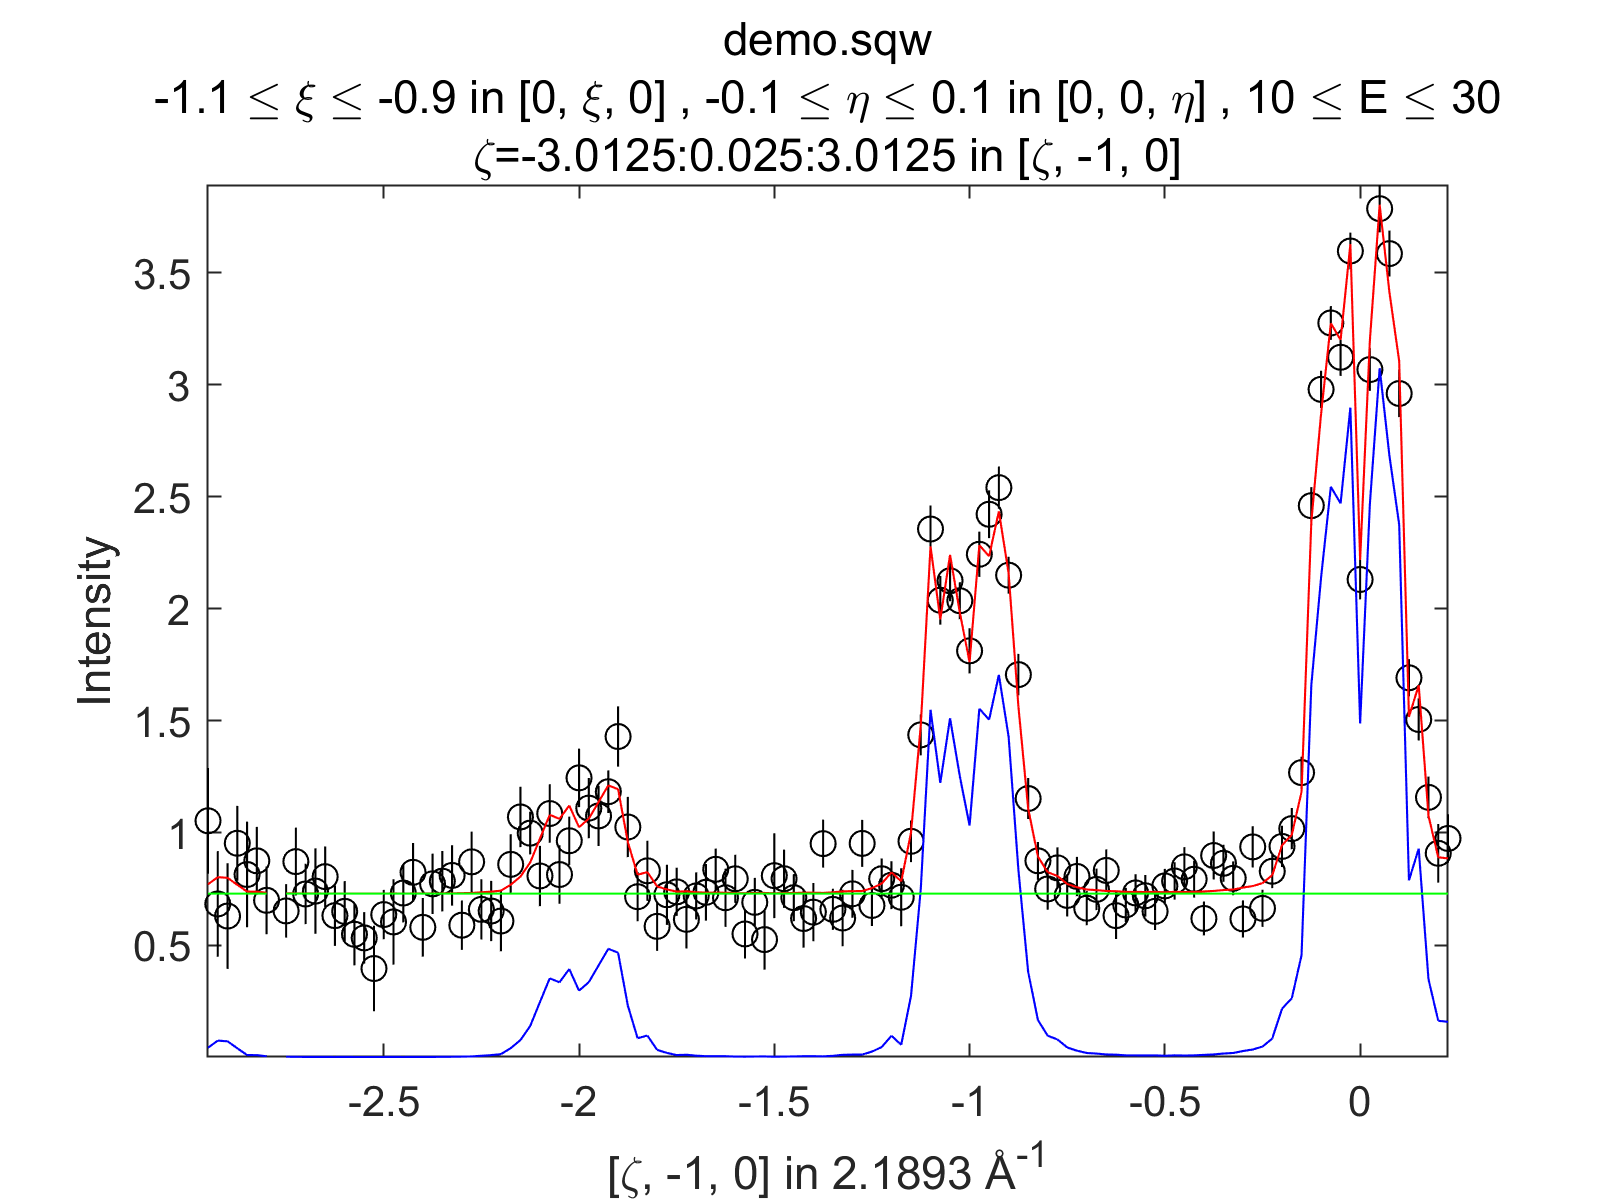

In [8]:
%matlab_fig -w 1600 -h 1200 
%matlab_plot_mode inline inline
index=0

m.acolor('k') #reset the color to black
m.plot(my_cuts[index]) #plot the data
m.acolor('r')
m.pl(wfit['sum'][index]) #draw a red line with the total fit
m.acolor('b')
m.pl(wfit['fore'][index]) #draw a blue line with the foreground/model without background
m.acolor('g')
m.pl(wfit['back'][index]) #draw a green line with the background


The fit (unsurprisingly) looks really nice. We can show the fit for all cuts as well.

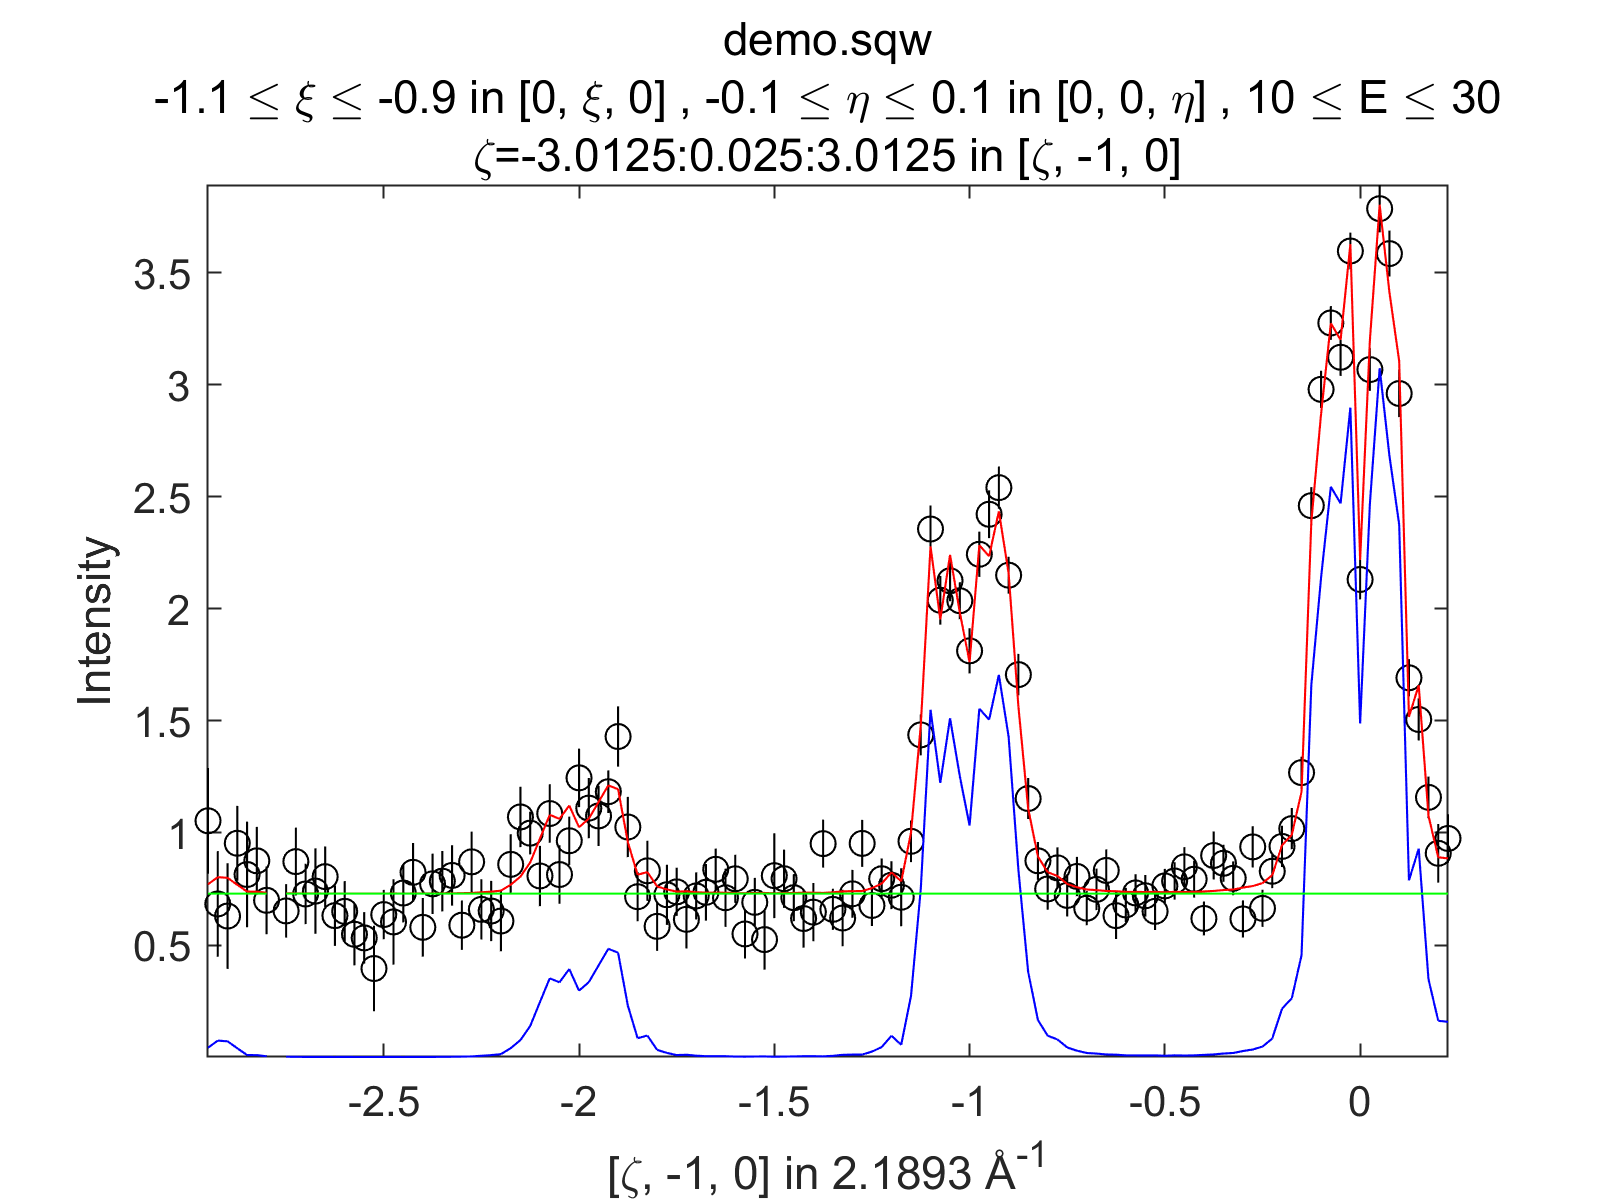

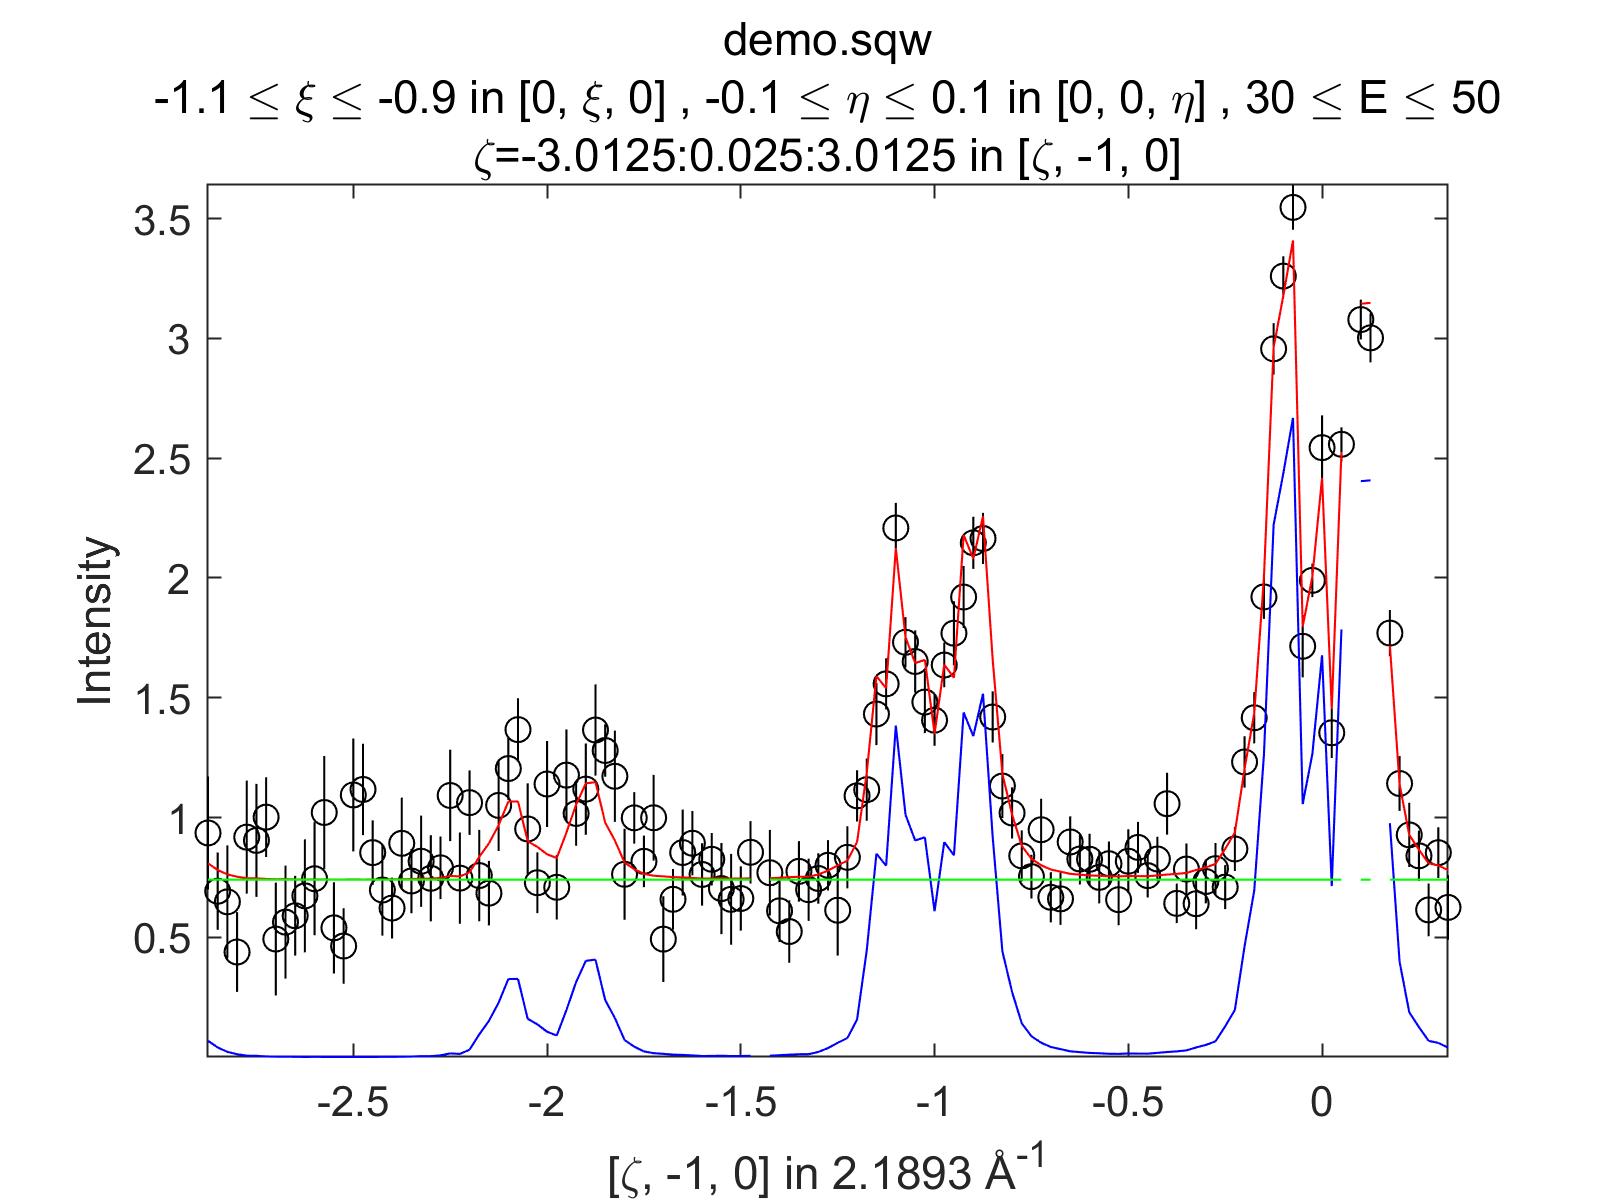

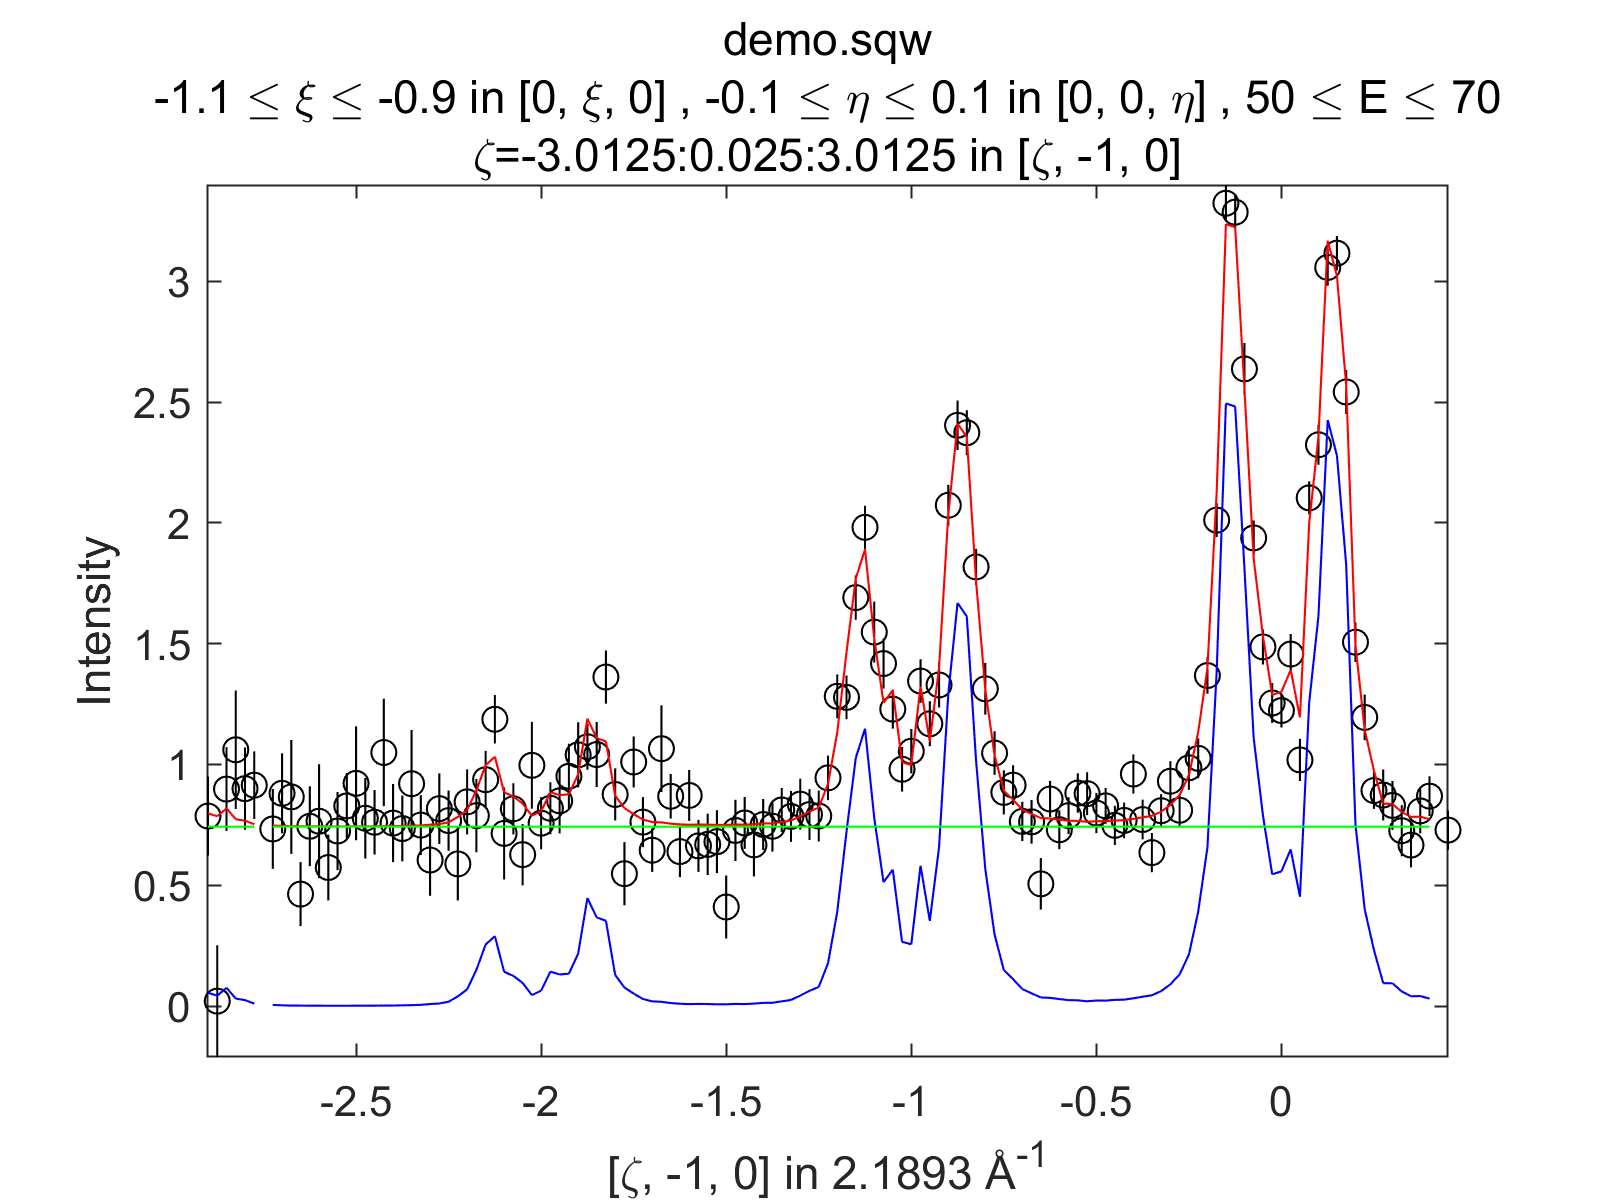

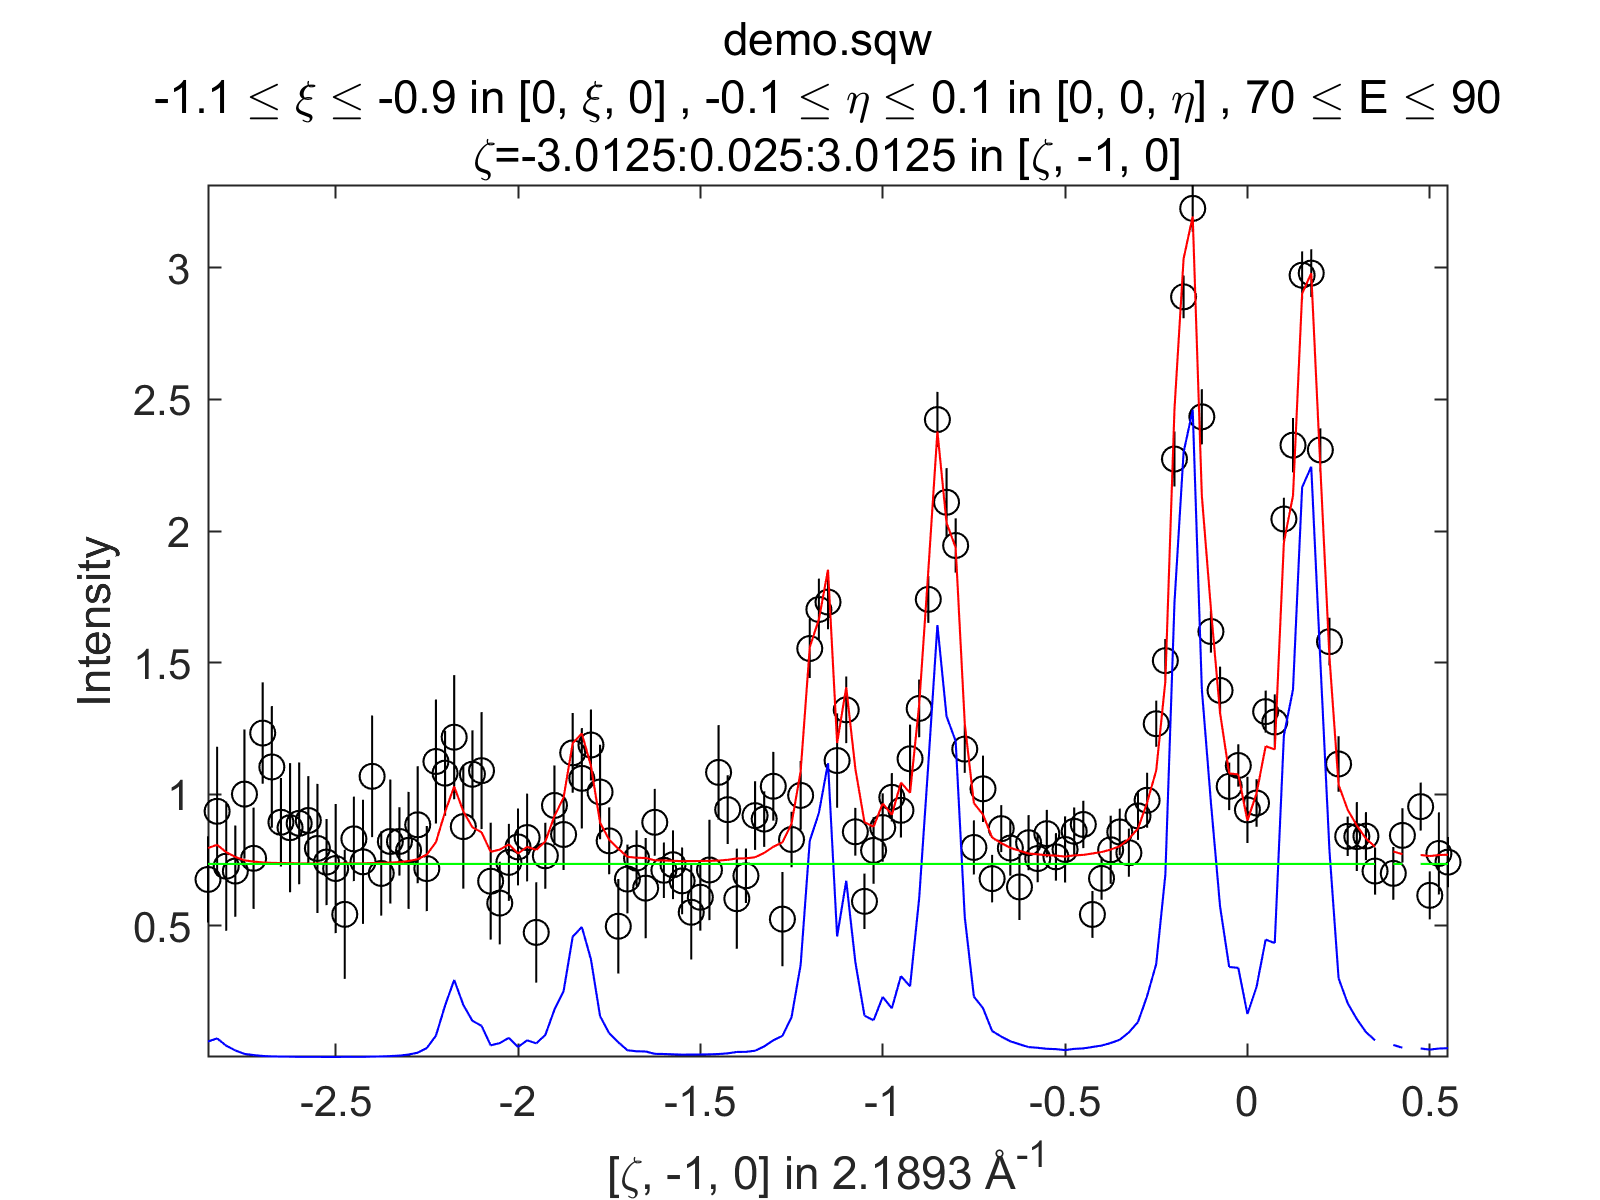

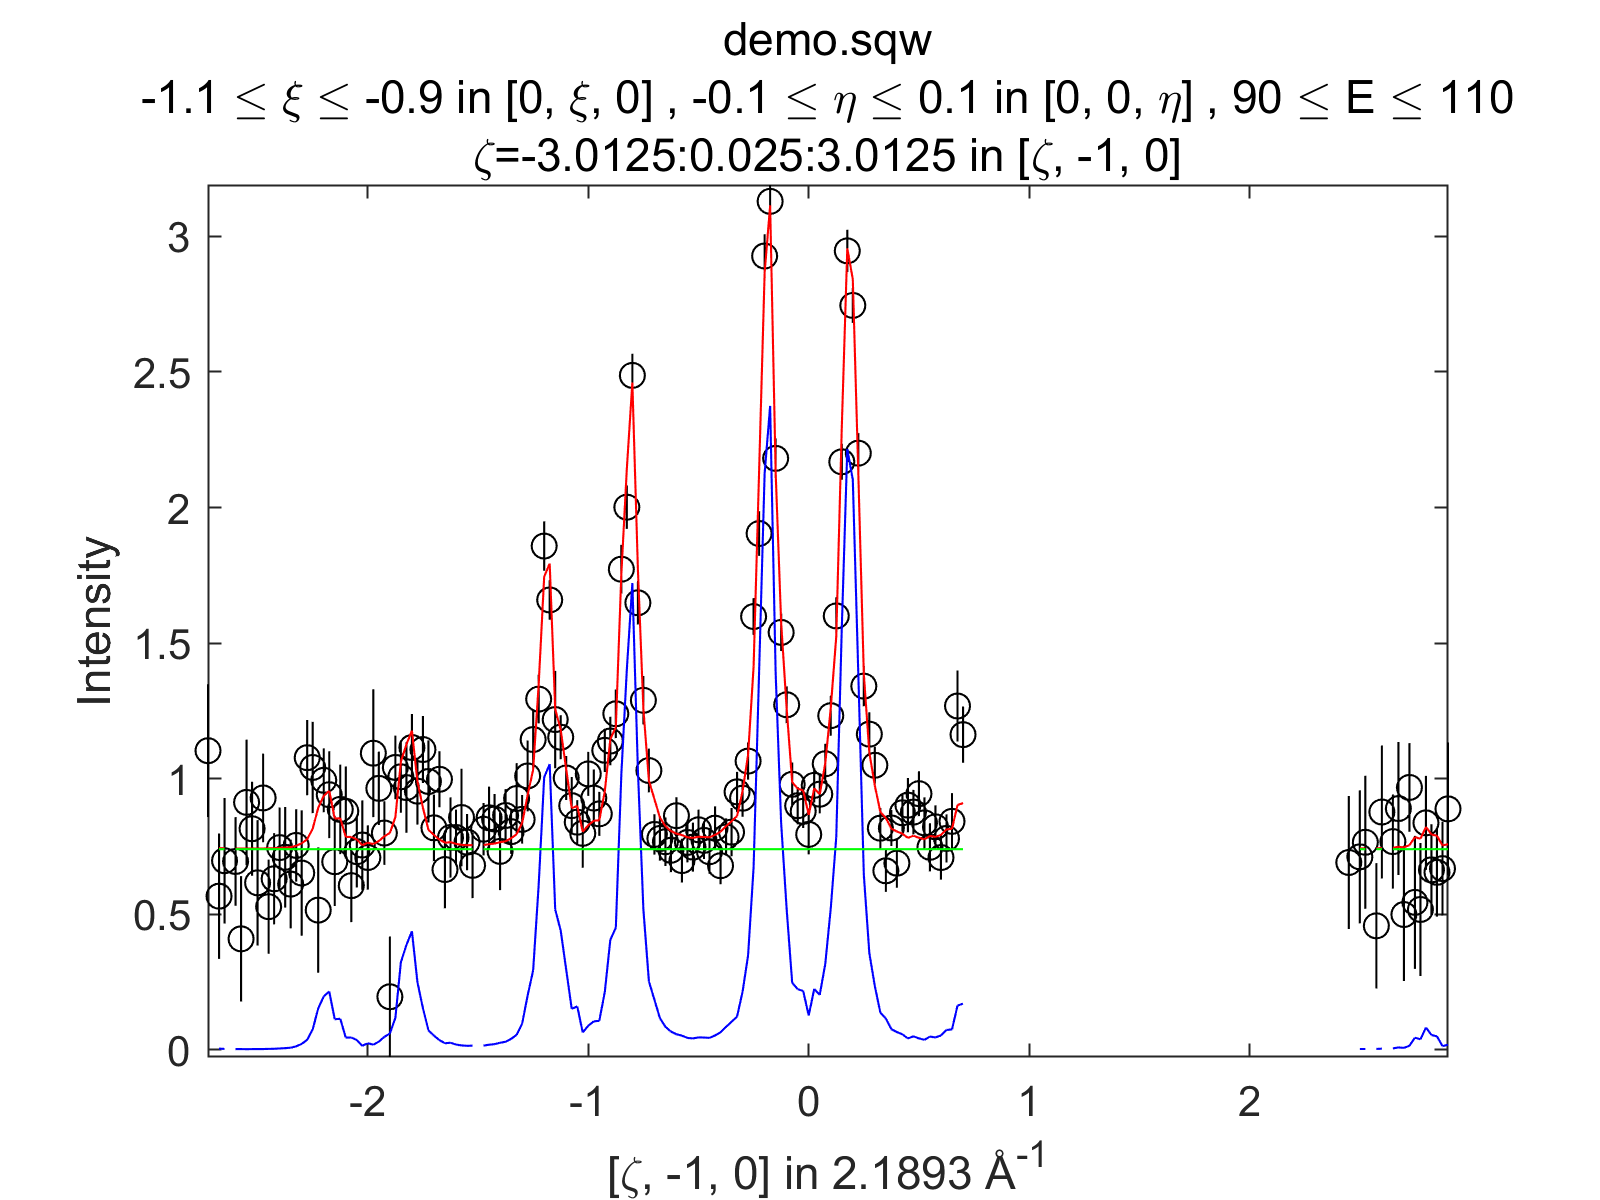

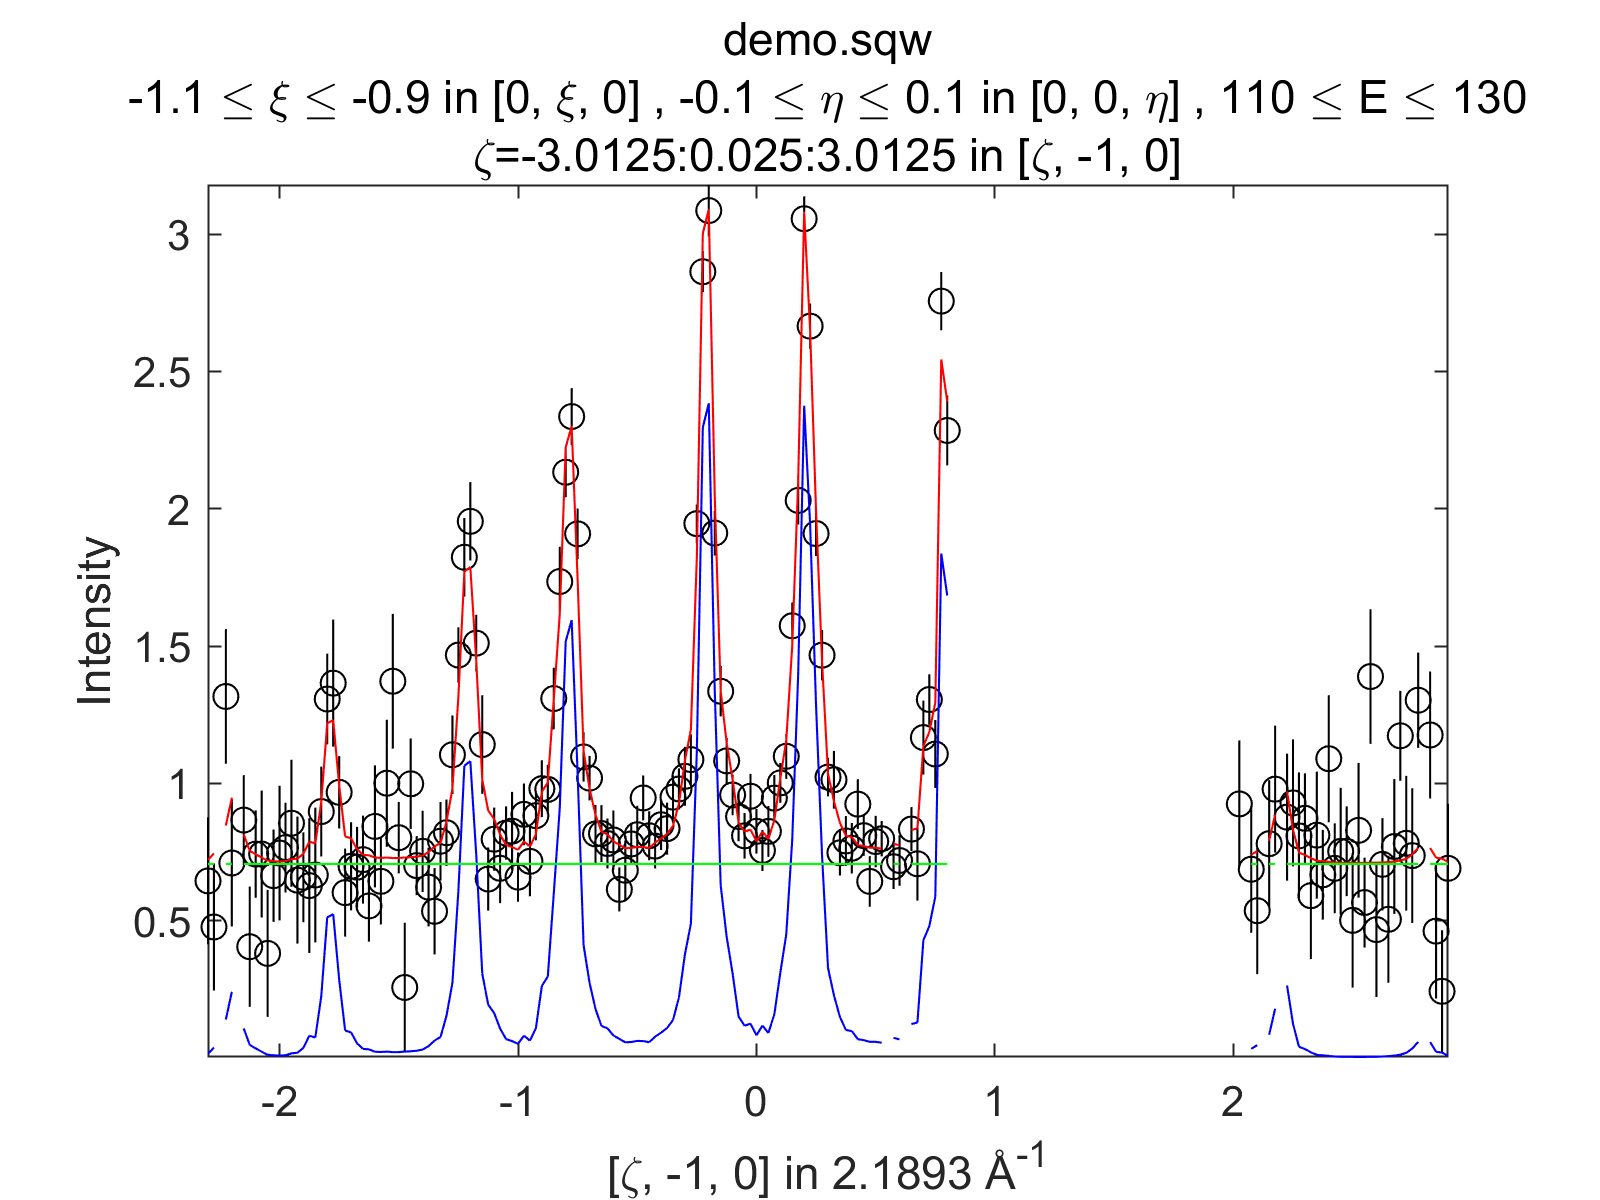

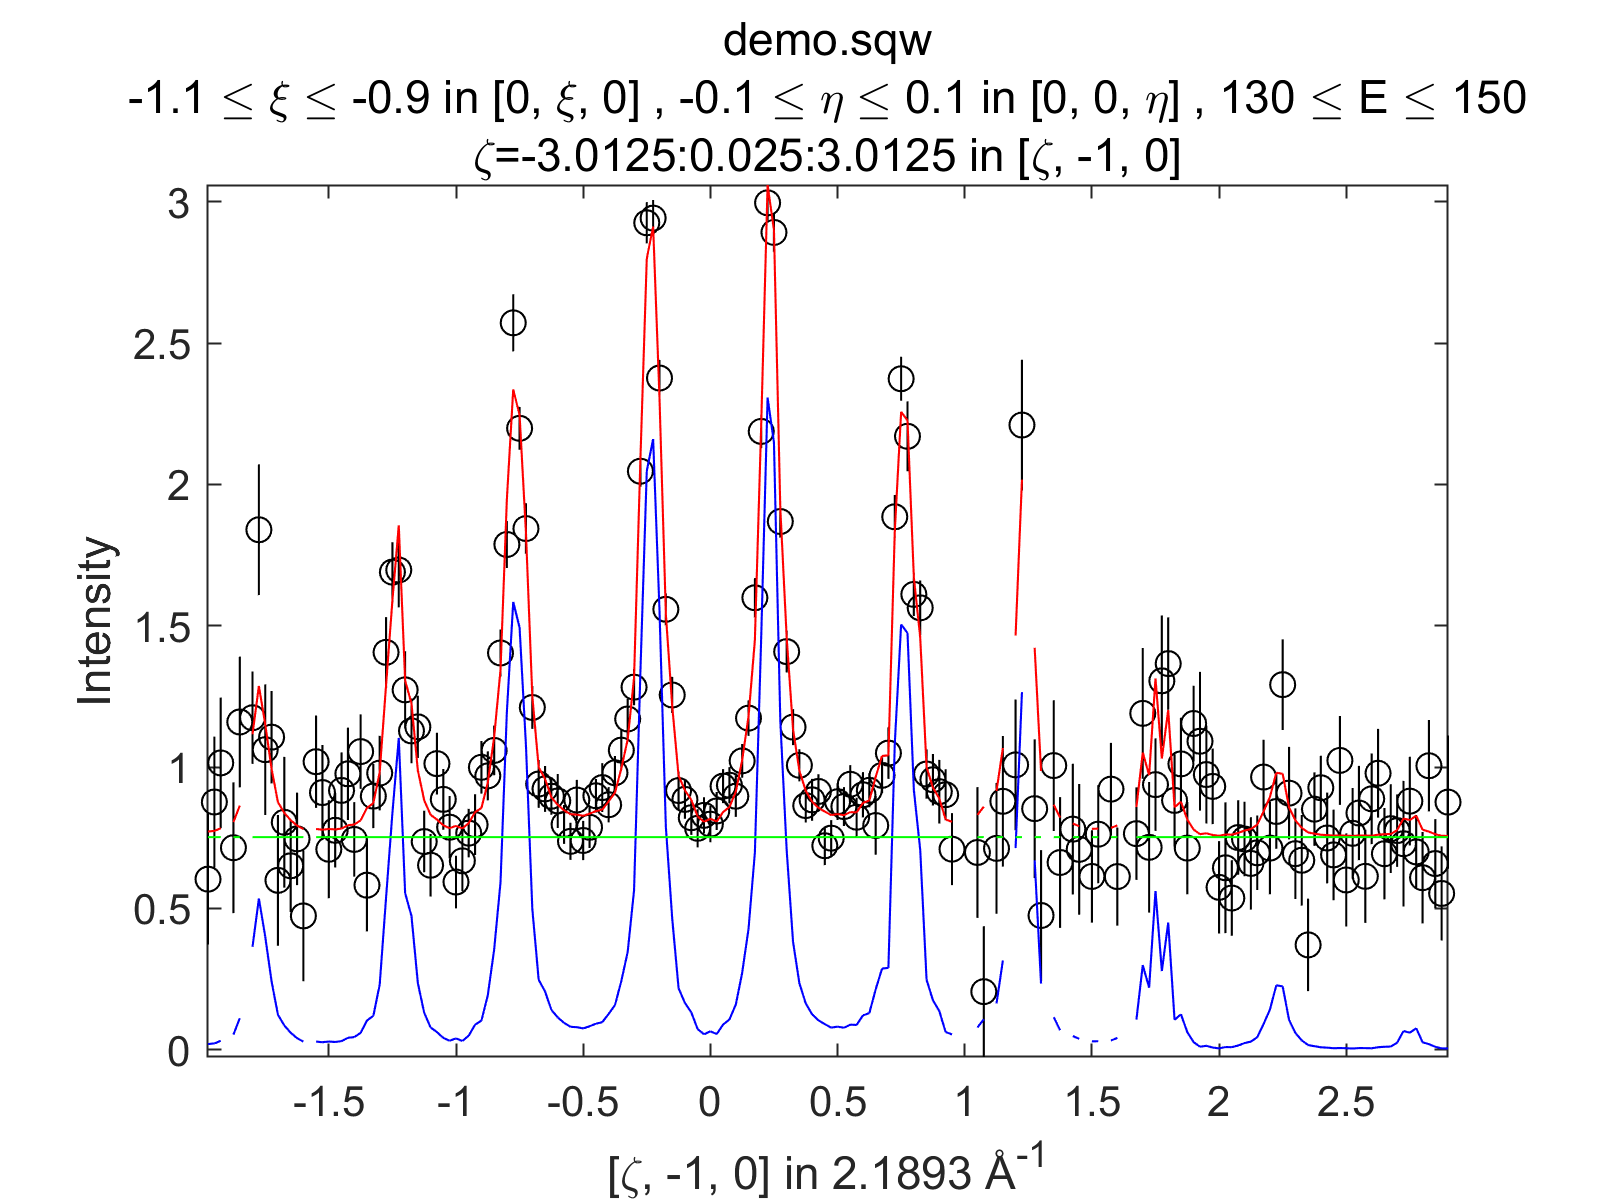

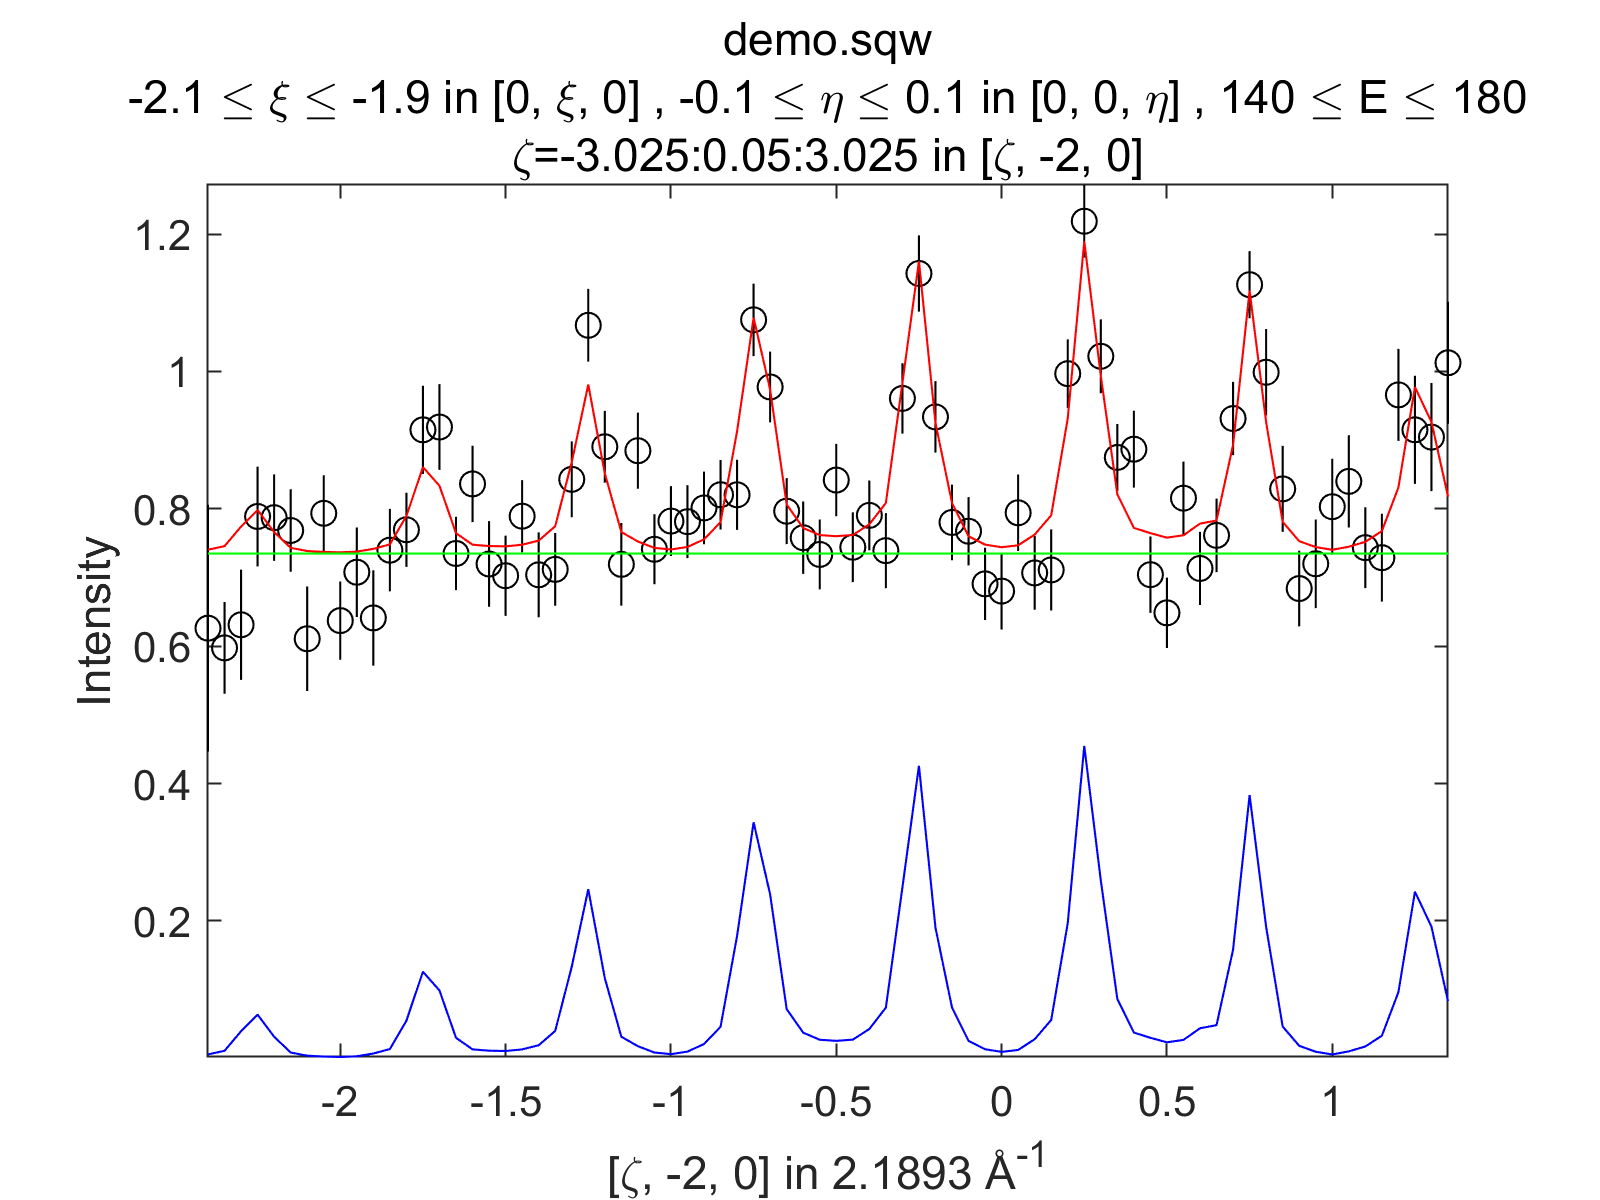

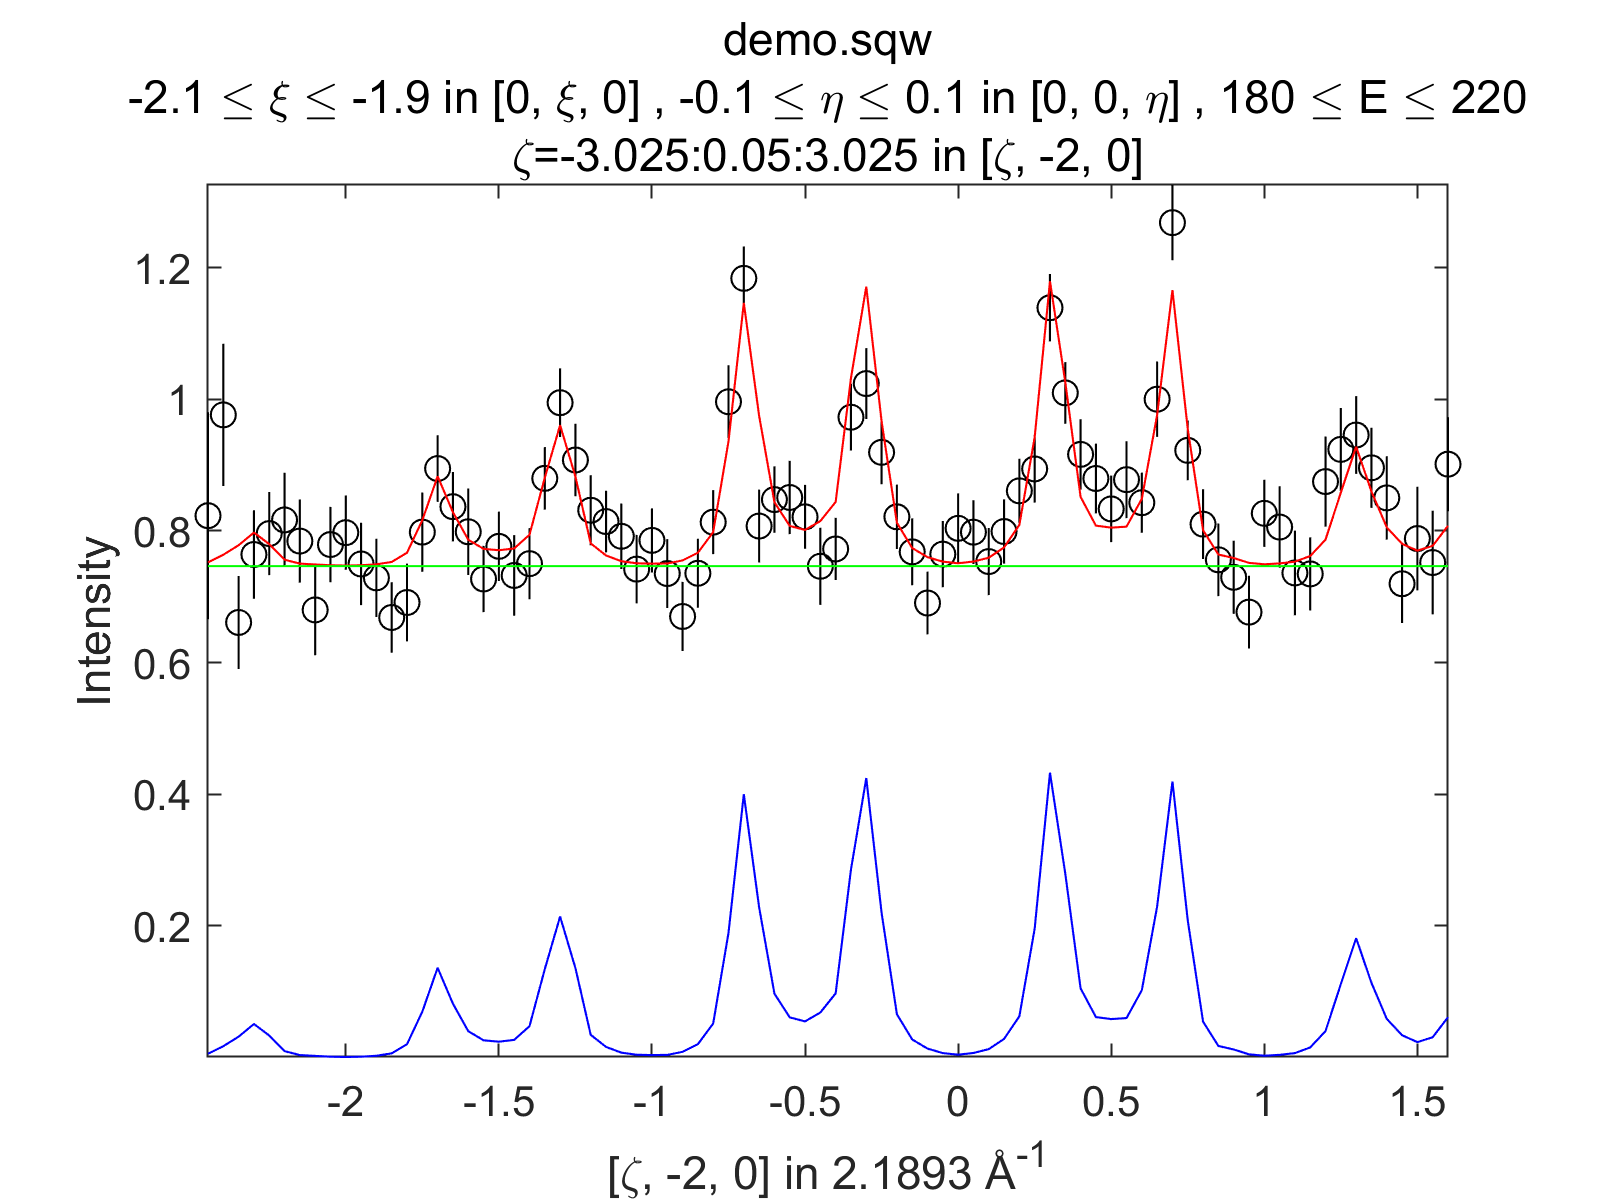

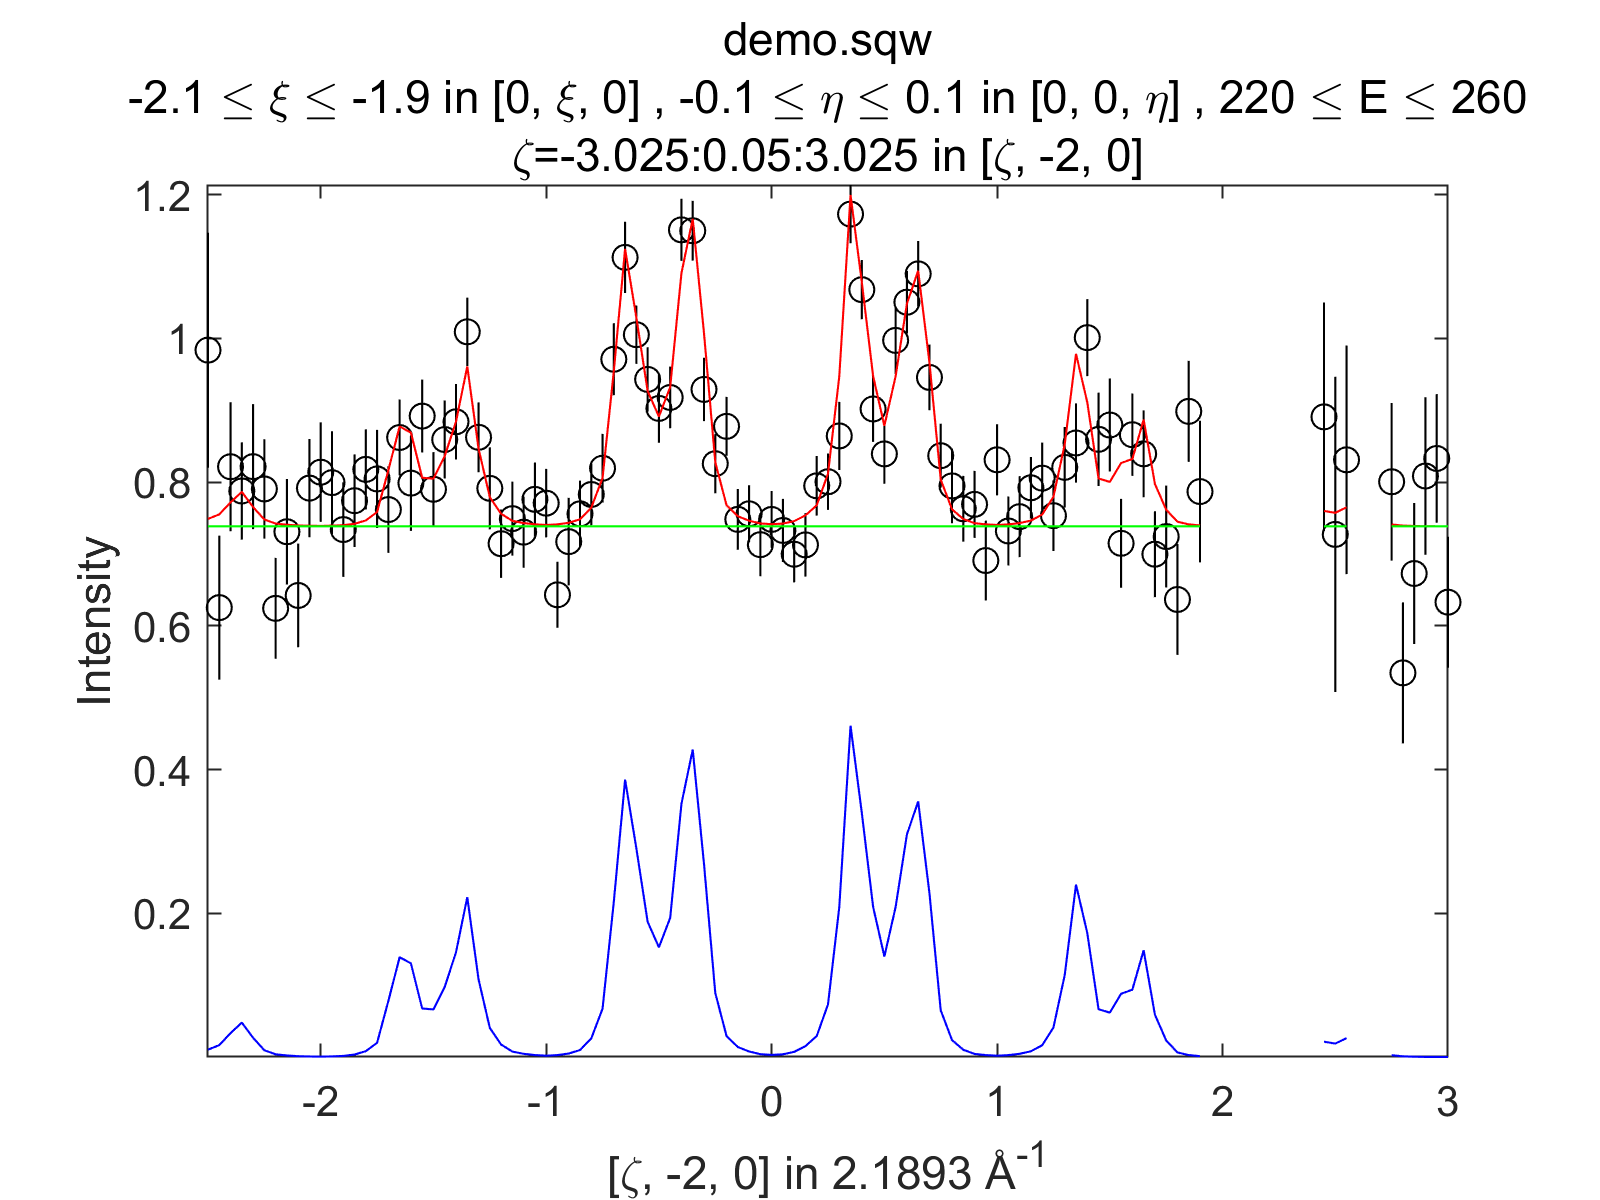

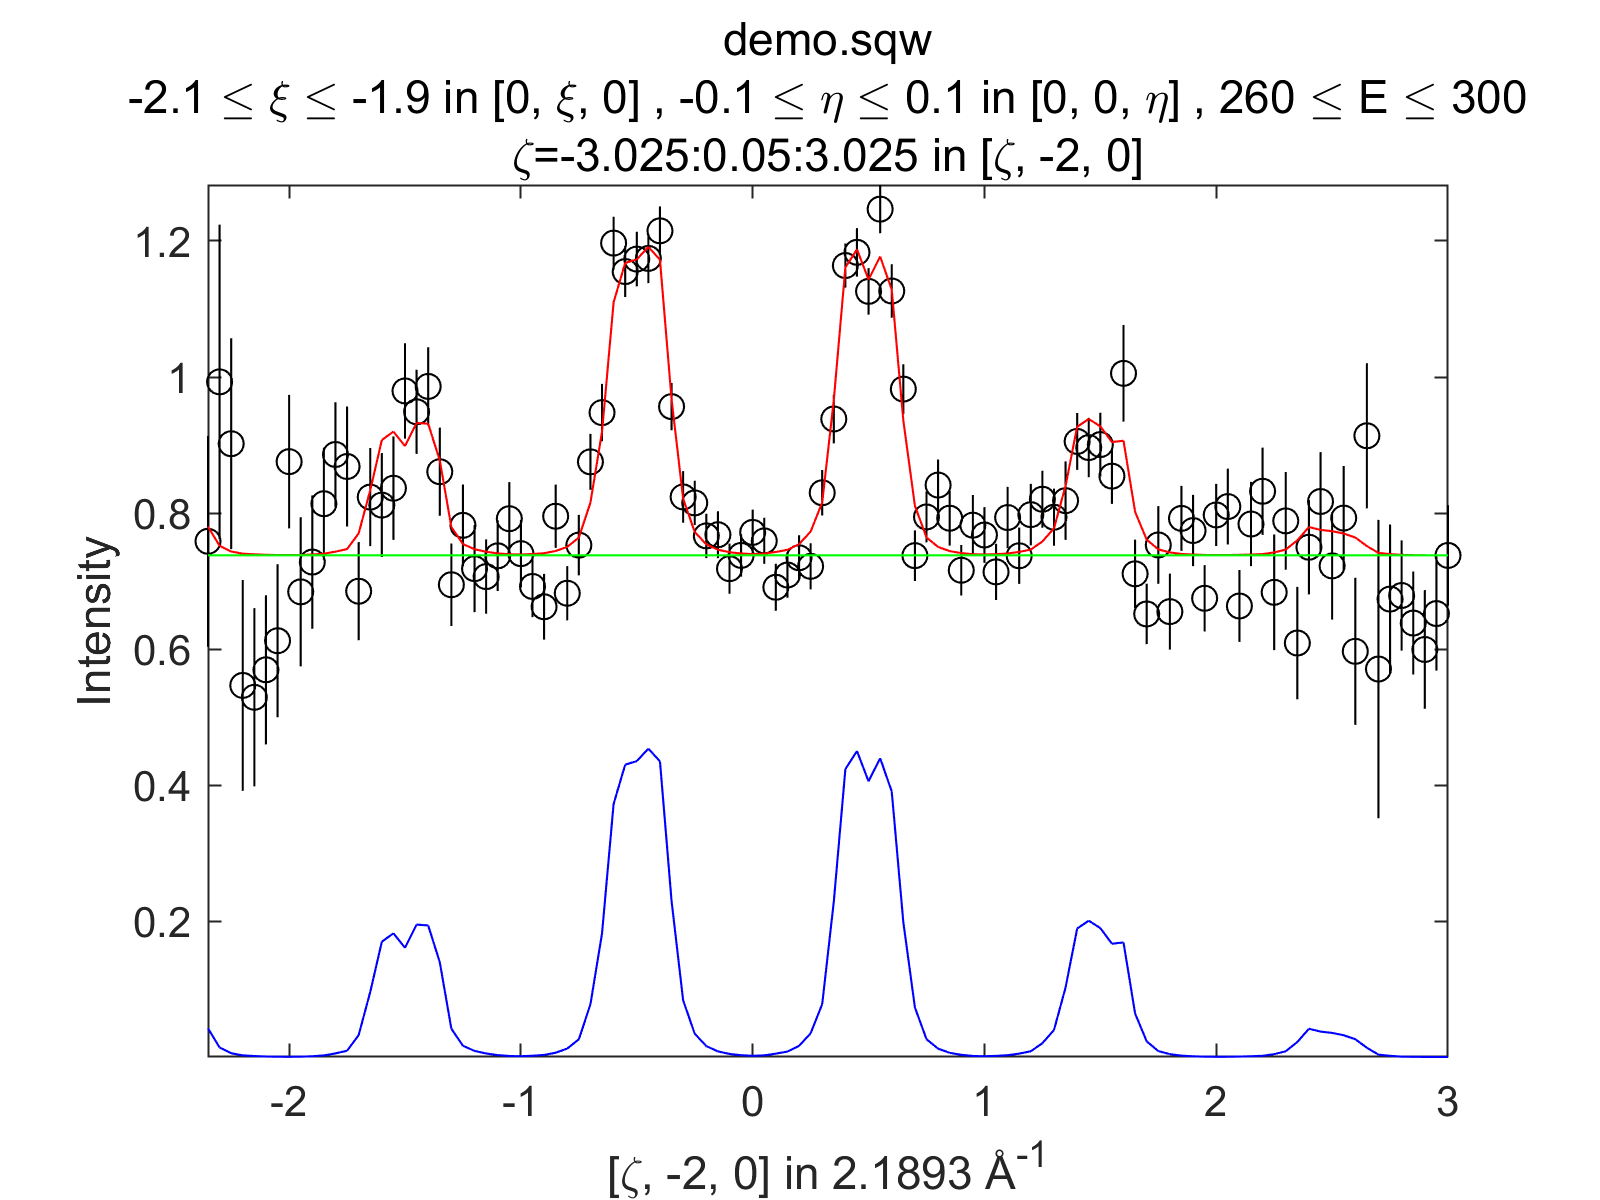

In [9]:
%matlab_fig -w 1600 -h 1200 
%matlab_plot_mode inline inline
index=0
for index in range(len(my_cuts)):
    m.acolor('k') #reset the color to black
    m.plot(my_cuts[index]) #plot the data
    m.acolor('r')
    m.pl(wfit['sum'][index]) #draw a red line with the total fit
    m.acolor('b')
    m.pl(wfit['fore'][index]) #draw a blue line with the foreground/model without background
    m.acolor('g')
    m.pl(wfit['back'][index]) #draw a green line with the background
    m.keep_figure()

m.acolor('k') #reset the color to black


Finally, we can inspect the fit parameters, stored in the second output, `fitdata`. It's a dictionary containing all the output of the fit. Let us print the most interesting things, i.e. the parameters describing our model, some of the background parameters, and the chi square:

In [ ]:
def pretty_array(arr):
    return np.array2string(arr, precision=4, suppress_small=True)

print("Fit parameters (p):", pretty_array(fitdata['p']))
print("Standard deviations (sig):", pretty_array(fitdata['sig']))
print("Background parameter 0 (bp[0]):", pretty_array(fitdata['bp'][0]))
print("Background std dev 0 (bsig[0]):", pretty_array(fitdata['bsig'][0]))
print("Background parameter 1 (bp[1]):", pretty_array(fitdata['bp'][1]))
print("Background std dev 1 (bsig[1]):", pretty_array(fitdata['bsig'][1]))
print("Chi-squared (chisq):", pretty_array(fitdata['chisq']))




Fit parameters (p): [[ 69.9515   0.      29.969   10.     501.6279]]
Standard deviations (sig): [[0.1653 0.     0.4624 0.     5.3363]]
Background parameter 0 (bp[0]): [[0.     0.7294]]
Background std dev 0 (bsig[0]): [[0.   0.01]]
Background parameter 1 (bp[1]): [[0.     0.7407]]
Background std dev 1 (bsig[1]): [[0.     0.0116]]
Chi-squared (chisq): [[1.0596]]
